# 0.0 Imports


In [1]:
# manipulação de dados
import pandas as pd
import numpy as np
import random
import math

# datas e tempo
import datetime
import time

# api
import requests
import json

# exportando arquivos
import pickle

# gráficos
from matplotlib import pyplot as plt
import matplotlib.gridspec as gs
import seaborn as sns

# machine learning
import boruta
import xgboost as xgb

from scipy import stats as ss
from sklearn.ensemble import RandomForestRegressor
from sklearn import linear_model as lm
from sklearn import metrics as mt
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder

# configuração do notebook
from IPython.core.display import HTML
from IPython.display import Image

## 1.1 Funções auxiliares

In [35]:
def cross_validation( x_training, kfold, model_name, model, verbose=False):
    
    mae_list = []
    mape_list = []
    rmse_list = []
    
    for k in reversed( range( 1, kfold+1 ) ):
        if verbose: # printa o número de K se verbose=True
            print( f'KFold Number: {k}' )
        
        # start and end date para validação
        validation_start_date = x_training['date'].max() - datetime.timedelta(days=k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta(days=(k-1)*6*7)
        
        # filtrando dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]
        
        # training and validation dataset
        # training
        xtraining = training.drop( ['date', 'sales'], axis=1 )
        ytraining = training['sales']
        
        # validation
        xvalidation = validation.drop( ['date', 'sales'], axis=1 )
        yvalidation = validation['sales']
                
        # modelo
        m = model.fit(xtraining, ytraining)
        
        # prediction
        yhat = m.predict( xvalidation )
        
        # performance
        m_result = ml_error( model_name, np.expm1(yvalidation), np.expm1(yhat) )
        
        # store performance of each kfold iteration
        mae_list.append( m_result['MAE'] )
        mape_list.append( m_result['MAPE'] )
        rmse_list.append( m_result['RMSE'] )
        
    return pd.DataFrame({
                'Model Name': model_name,
                'MAE CV': np.round( np.mean( mae_list ), 2 ).astype(str) + ' +/- ' + np.round( np.std( mae_list ), 2 ).astype( str ),
                'MAPE CV': np.round( np.mean( mape_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mape_list ), 2 ).astype( str ),
                'RMSE CV': np.round( np.mean( rmse_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( rmse_list ), 2 ).astype( str )
                },
                index=[0] )

def cramer_v(x, y):
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
    kcorr = k - (k-1)**2 / (n-1)
    rcorr = r - (r-1)**2 / (n-1)
    
    return np.sqrt((chi2corr/n) / (min(kcorr-1, rcorr-1)))
    
def jupyter_settings():
    %matplotlib inline
                
    # Confirgurações para o matplotlib
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24

    display( HTML( '<style>.container { width:80% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.options.display.float_format = '{:.2f}'.format
    pd.set_option( 'display.expand_frame_repr', False )
    # pd.option_context('mode.use_inf_as_na', True)

def ml_error(nome_modelo, y, yhat):
    
    mae = mt.mean_absolute_error(y, yhat)
    mape = mt.mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt( mt.mean_squared_error(y, yhat))
    
    return pd.DataFrame({'Modelo': nome_modelo,
                        'MAE': mae,
                        'MAPE': mape,
                        'RMSE': rmse}, index=[0])

In [ ]:
jupyter_settings()

## 0.2 Carregando dados

In [ ]:
 # Dados unitários
df_sales_raw = pd.read_csv('../datasets/raw/train.csv', low_memory=False)
df_store_raw = pd.read_csv('../datasets/raw/store.csv', low_memory=False)

# dataset mesclado
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')   

## 1.0 Descrição dos dados

In [ ]:
df1 = df_raw.copy()

### 1.1 Renomeando as colunas

In [ ]:
# colunas atuais do dataset
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
            'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
            'CompetitionDistance', 'CompetitionOpenSinceMonth',
            'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
            'Promo2SinceYear', 'PromoInterval']

# coloca as colunas com letras minusculas
snakecase = lambda x: inflection.underscore(x)

# cria as colunas padronizadas
cols_new = list(map(snakecase, cols_old))

# insere os novos nomes de colunas no dataset
df1.columns = cols_new


### 1.2 Dimensão dos dados

In [ ]:
print(f'Número de linhas: {df1.shape[0]}')
print(f'Número de linhas: {df1.shape[1]}')

Número de linhas: 1017209
Número de linhas: 18


### 1.3 Conversão do tipo de dados

In [ ]:
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

### 1.4 Checagem de NA

In [ ]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

### 1.5 Preenchimento de NA

In [ ]:
# Retornando o valor máximo da coluna "competition_distance"
df1['competition_distance'].max()

75860.0

In [ ]:
# competition_distance
# - O valor 200000 foi atribuído para simbolizar que a distancia de uma loja para outra é tão grande que não há competição entre as lojas
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

# competition_open_since_month
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

# competition_open_since_year
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

# promo2_since_week
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

# promo2_since_year
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

# promo_interval
# dicionario que altera o número do mês pelo nome do mês
month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Out', 11: 'Nov', 12: 'Dec'}

# substitui os na pelo valor 0
df1['promo_interval'].fillna(0, inplace=True)

# extrai o mês da data
df1['month_map'] = df1['date'].dt.month.map(month_map)

# verifica se o month map está contido na promo2
df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

In [ ]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

### 1.6 Alterando tipos de dados

In [ ]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype('int64')
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype('int64')
df1['promo2_since_week'] = df1['promo2_since_week'].astype('int64')
df1['promo2_since_year'] = df1['promo2_since_year'].astype('int64')

### 1.7 Estatistica Descritiva

Objetivos:
1. Ganho de conhecimento de negócio
2. Conseguir detectar alguns erros

Métricas:
1. Tendencia Central: média, mediana
2. Dispersão: std, min, max, range, skew, kurtoises

In [ ]:
# variáveis númericas
num_attributes = df1.select_dtypes(include=['int64', 'float64'])

# variáveis categóricas
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

#### 1.7.1 Atributos númericos

In [ ]:
# Tendencia central: media, mediana
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersaão: std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply( np.std )).T
d2 = pd.DataFrame(num_attributes.apply( min )).T
d3 = pd.DataFrame(num_attributes.apply( max )).T
d4 = pd.DataFrame(num_attributes.apply( lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply( lambda x: x.skew() )).T
d6 = pd.DataFrame(num_attributes.apply( lambda x: x.kurtosis() )).T
                                       
# Concatenate
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


c:\Users\garri\anaconda3\envs\ds_producao\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


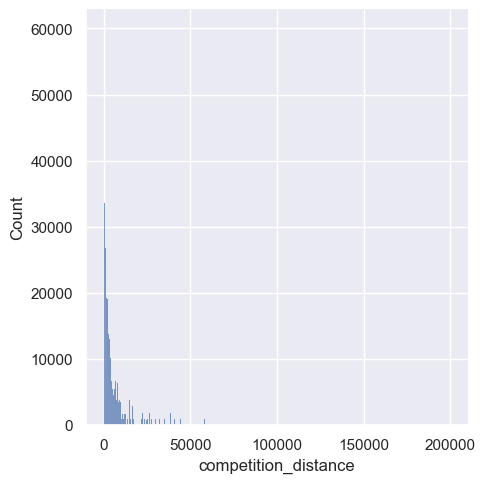

In [ ]:
sns.displot(df1['competition_distance'], kde=False)

#### 1.7.2 Atributos categóricos

In [ ]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<Axes: xlabel='assortment', ylabel='sales'>

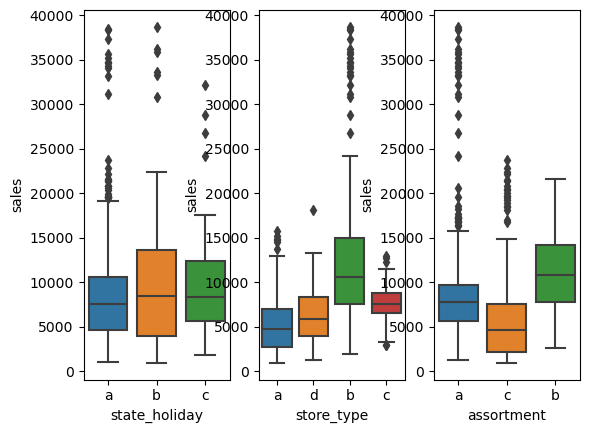

In [ ]:
aux = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.subplot(1, 3, 1)
sns.boxplot(x='state_holiday', y='sales', data=aux)

plt.subplot(1, 3, 2)
sns.boxplot(x='store_type', y='sales', data=aux)

plt.subplot(1, 3, 3)
sns.boxplot(x='assortment', y='sales', data=aux)

# 2.0 Feature Engineering (Engenharia de dados)

In [ ]:
df1 = pickle.load(open('../datasets/processed/pkl/processed_data.pkl', 'rb'))

### 2.1. Mapa Mental de Hipóteses

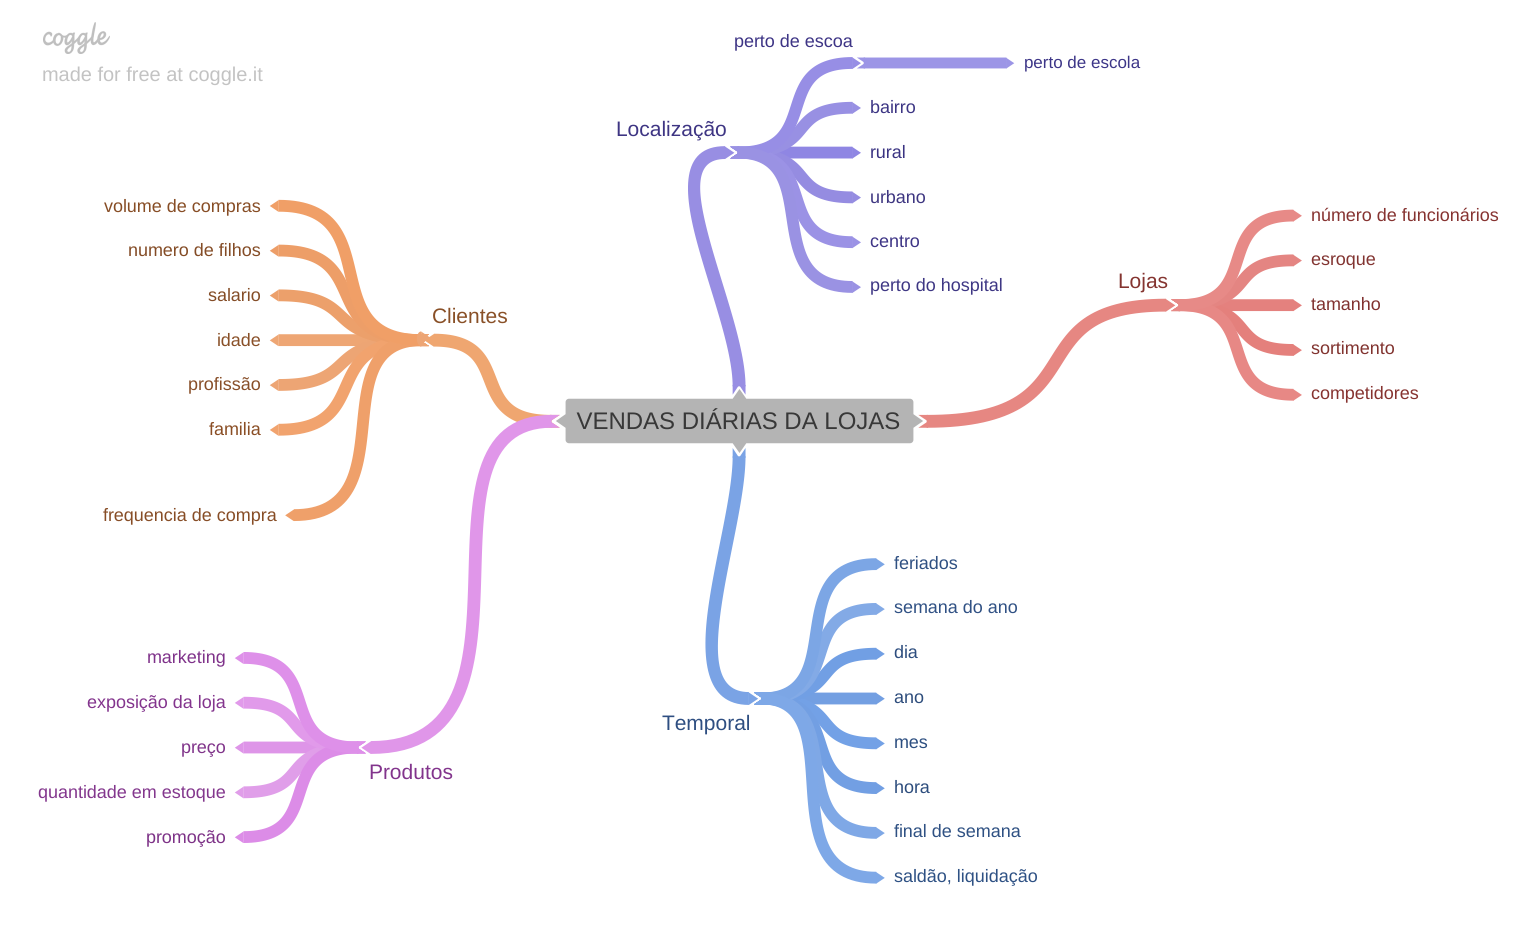

In [ ]:
Image('../img/mindmap_hipoteses.png')

## 2.2 Criação das hipóteses

### 2.2.1. Hipóteses Loja
1. Lojas com maior quadro de funcionários deveriam vender mais.
2. Lojas com maior capacidade de estoque deveriam vender mais.
3. Lojas com maior porte deveriam vender mais.
4. Lojas com maior sortimento deveriam vender mais.
5. Lojas com competidores mais próximos deveriam vender menos.
6. Lojas com competidores à mais tempo deveriam vender mais.

### 2.2.2. Hipóteses Produto
1. Lojas que investem mais em Marketing deveriam vender mais.
2. Lojas com maior exposição de produtos deveriam vender mais.
3. Lojas que tem preços menores nos produtos deveriam vender mais.
4. Lojas com promoções mais agressivas (mais descontos) deveriam vender mais.
5. Lojas com promoções ativas por mais tempo deveriam vender mais.
6. Lojas com mais dias de promoção deveriam vender mais.
7. Lojas com mais promoções consecutivas deveriam vender mais.

### 2.2.3 Hipóteses Tempo
1. Lojas deveriam vender mais ao longo dos anos.
2. Lojas deveriam vender mais no segundo semestre do ano.
3. Lojas deveriam vender mais depois do dia 10 de cada mês.
4. Lojas deveriam vender menos aos finais de semana.
5. Lojas deveriam vender menos durante os feriados escolares.

### 2.2.4 Lista Final de Hipóteses

1. Lojas com maior sortimento deveriam vender mais.
2. Lojas com competidores mais próximos deveriam vender menos.
3. Lojas com competidores à mais tempo deveriam vender mais.
4. Lojas com promoções ativas por mais tempo deveriam vender mais.
5. Lojas com mais dias de promoção deveriam vender mais.
6. Lojas com mais promoções consecutivas deveriam vender mais.
7. Loas abertas durante o feriado de Natal deveriam vender mais.
8. Lojas deveriam vender mais ao longo dos anos.
9.  Lojas deveriam vender mais no segundo semestre do ano.
10. Lojas deveriam vender mais depois do dia 10 de cada mês.
11. Lojas deveriam vender menos aos finais de semana.
12. Lojas deveriam vender menos durante os feriados escolares.

In [ ]:
df2 = df1.copy()

In [ ]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week

# year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

# competiton since
df2['competition_since'] = (df2.apply( lambda x: datetime.datetime(year=x['competition_open_since_year'],
                                                                   month=x['competition_open_since_month'],
                                                                   day=1), axis=1 ))

df2['competition_time_month'] = ((df2['date'] - df2['competition_since'] ) / 30).apply(lambda x: x.days).astype('int64')

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))
df2['promo_time_week'] = ((df2['date'] - df2['promo_since']) / 7).apply(lambda x: x.days).astype('int64')

# assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public' if x == 'a' else 'easter_holiday' if x == 'b'else 'christmas' if x == 'c' else 'regular_day')

# 3.0 Filtro de Variaveis

1. customers: quantos clientes haviam na loja quando as lojas fizeram vendas
2. open: selecionando apenas as colunas que estão abertas, ou seja `'open' == 0`
3. promo_interval: não será significativa no modelo. Variável derivada de outra coluna.
4. month_map: não será significativa no modelo. Variável derivada de outra coluna.

In [ ]:
df3 = pickle.load(open('../datasets/interim/pkl/02_engenharia_variaveis.pkl', 'rb'))

### 3.1 Filtragem das linhas

Filtrando as linhas do dataset:
1. Onde `open != 0` é referente as lojas que estão abertas
2. Onde `sales` é maior que zero ocasionando em lojas que tenham vendas acima de zero

In [ ]:
df3 = df3[ (df3['open'] != 0) & (df3['sales'] > 0) ]

### 3.2 Seleção das Colunas

In [ ]:
# Seleção das colunas
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']

# Exclusão das colunas
df3 = df3.drop(cols_drop, axis=1)

# 4.0 Analise Exploratoria de Dados

In [ ]:
df4 = df3.copy()

In [ ]:
pickle.dump(df4, open('../datasets/interim/pkl/03_filtragem_variaveis.pkl', 'wb'))

In [ ]:
# variáveis númericas
num_attributes = df4.select_dtypes(include=['int64', 'float64'])

# variáveis categóricas
cat_attributes = df4.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

## 4.1 Análise Univariada

### 4.1.1 Variável resposta (target)

c:\Users\garri\anaconda3\envs\ds_producao\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


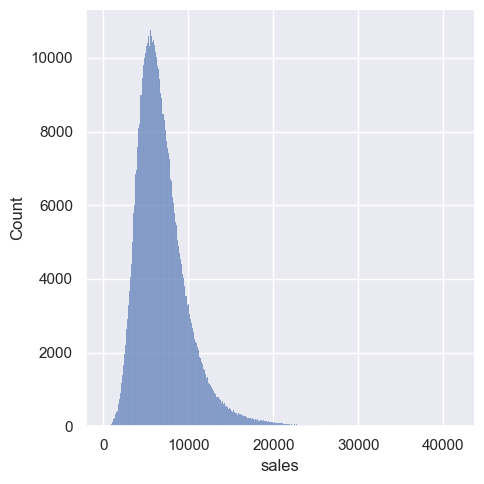

In [ ]:
sns.displot(df4['sales'], kde=False);

### 4.1.2 Variável numérica
- "bins" = quantidade máxima de barras para representar os dados no gráfico.

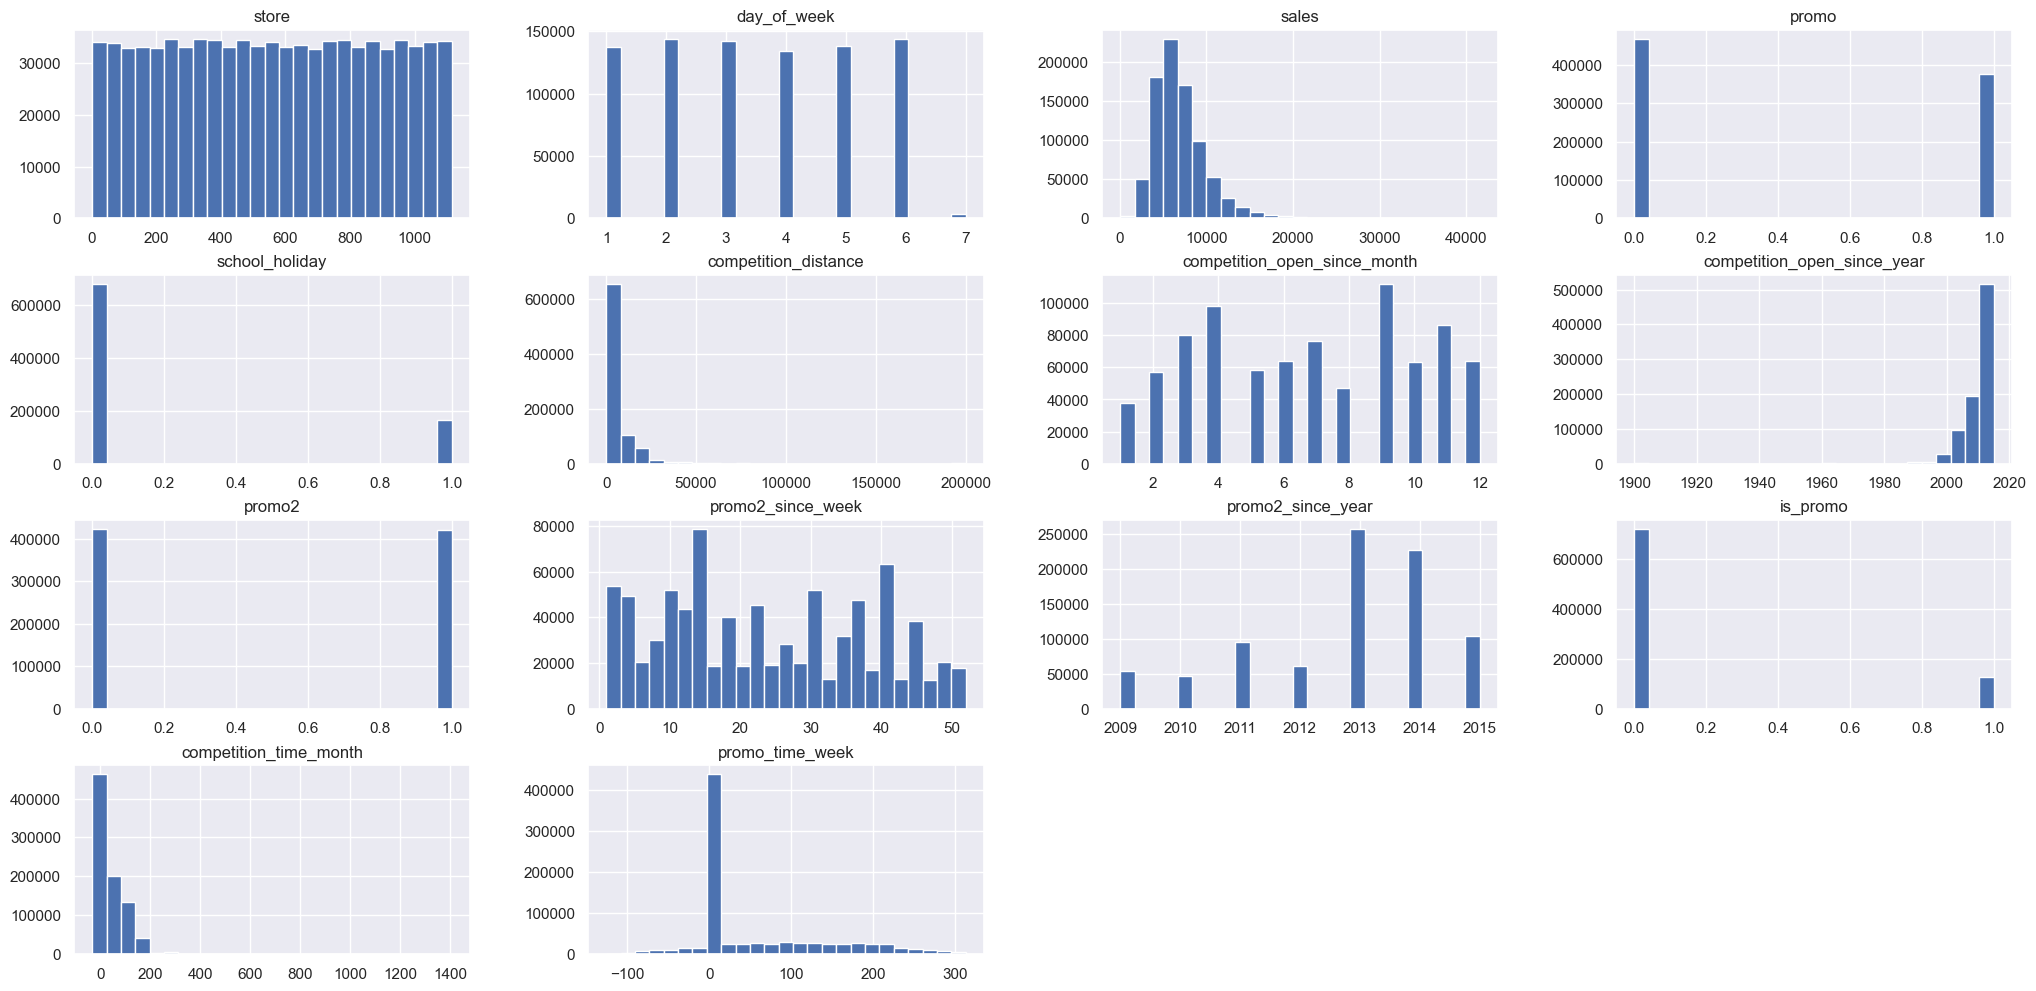

In [ ]:
num_attributes.hist(bins=25);

### 4.1.3 Variável categórica

In [ ]:
df4['state_holiday'].drop_duplicates()

0            regular_day
63559             public
129424    easter_holiday
241126         christmas
Name: state_holiday, dtype: object

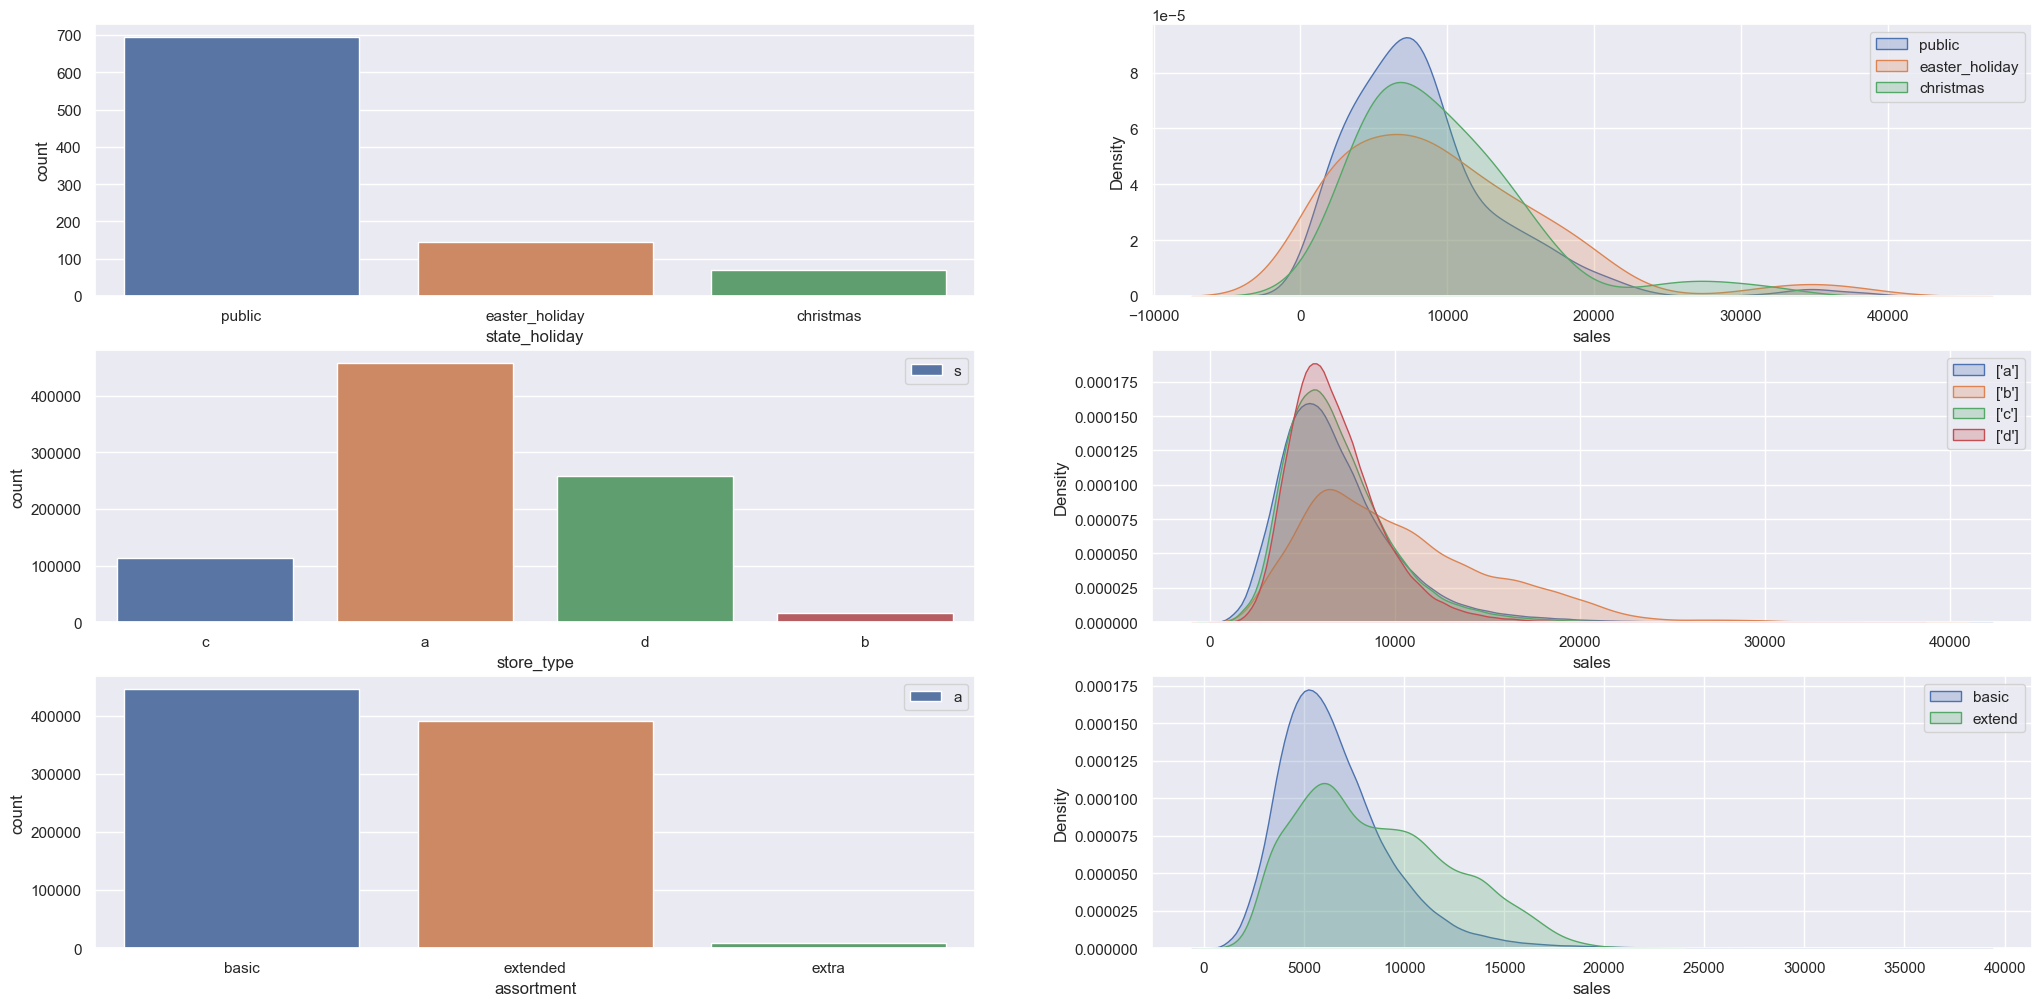

In [ ]:
# state_holiday
plt.subplot(3,2,1)
st_hol = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(st_hol, x='state_holiday');

plt.subplot(3,2,2)
sns.kdeplot(df4[df4['state_holiday'] == 'public']['sales'], label='public', fill=True);
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', fill=True);
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', fill=True);

# story_type
plt.subplot(3,2,3)
sns.countplot(df4, x='store_type');

plt.subplot(3,2,4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label='a', fill=True);
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label='b', fill=True);
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label='c', fill=True);
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label='d', fill=True);

# assortment
plt.subplot(3,2,5)
sns.countplot(df4, x='assortment');

plt.subplot(3,2,6)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label='basic', fill=True);
sns.kdeplot(df4[df4['assortment'] == 'extend']['sales'], label='extend', fill=True);
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label='extra', fill=True);

## 4.2 Análise Bivariada

### H1. Lojas com maior sortimentos deveriam vender mais
- Compara o `assortment` com `vendas`
- **FALSO** Lojas com MAIOR SORTIMENTO vendem MENOS


<Axes: xlabel='year_week'>

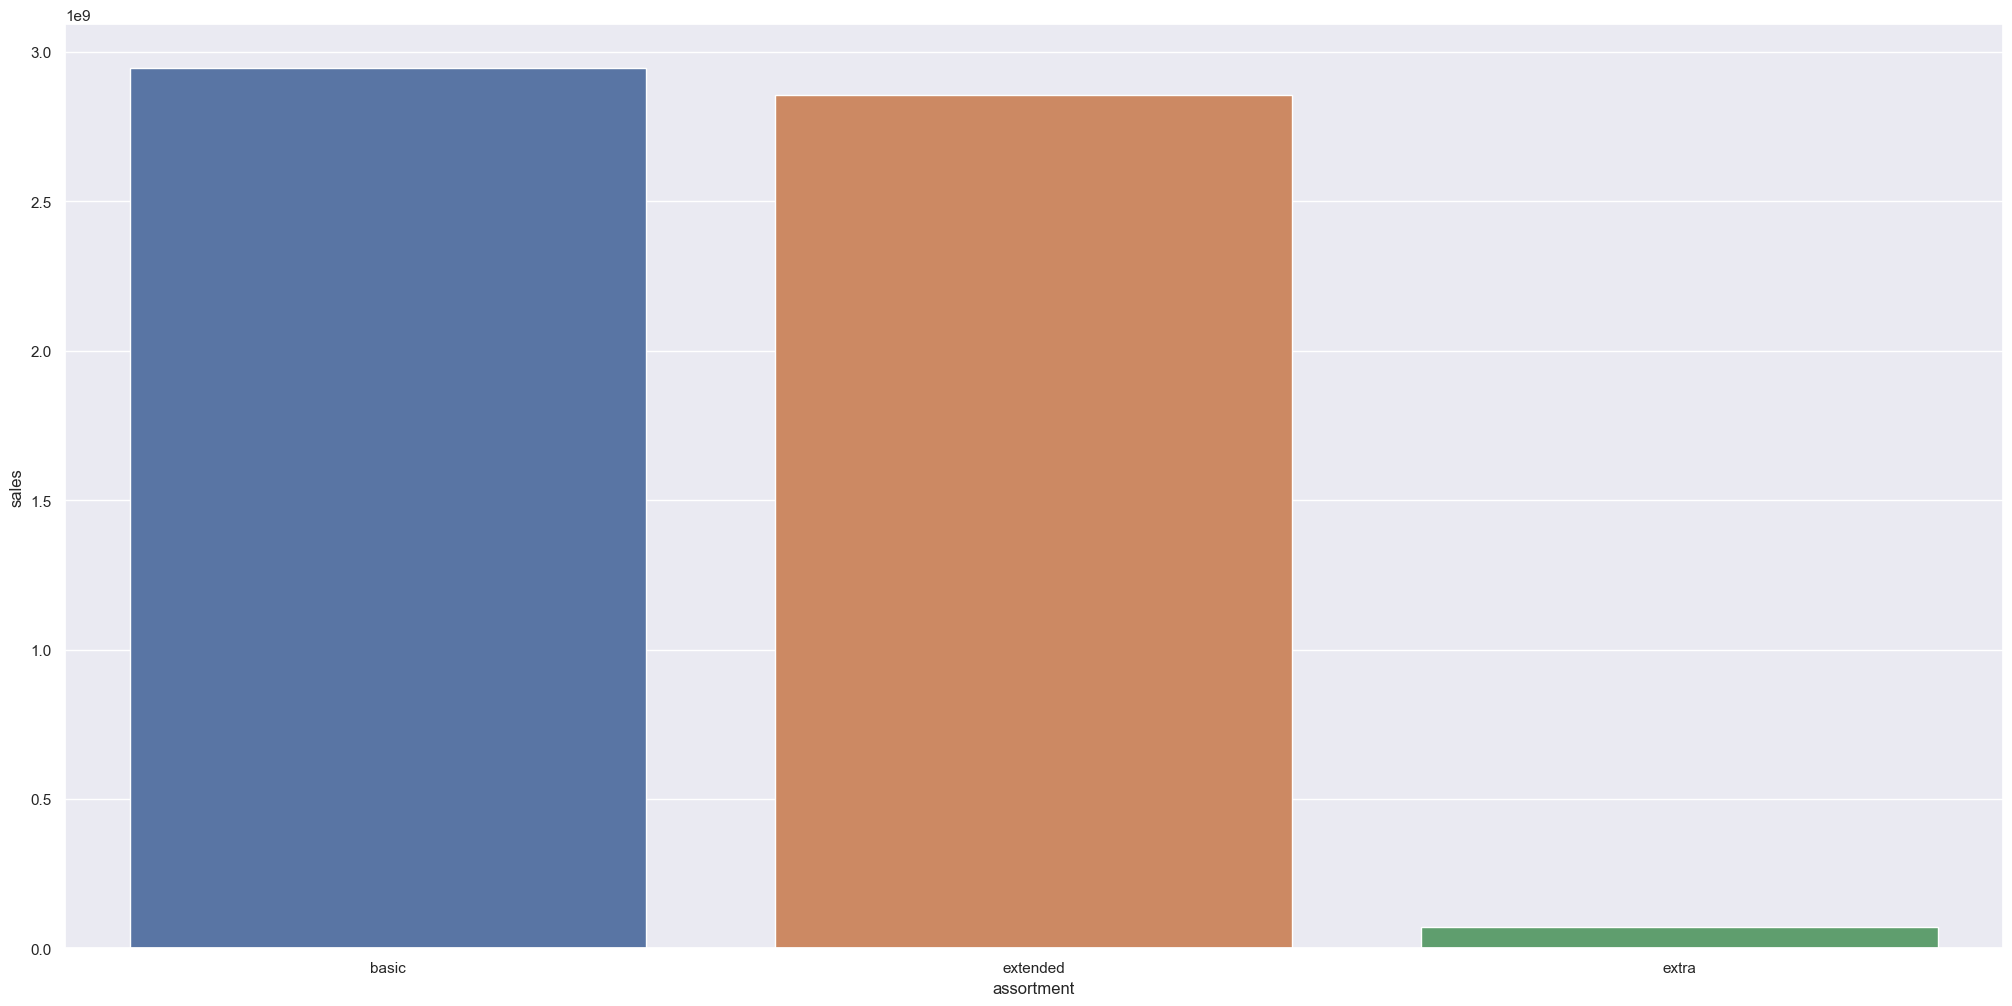

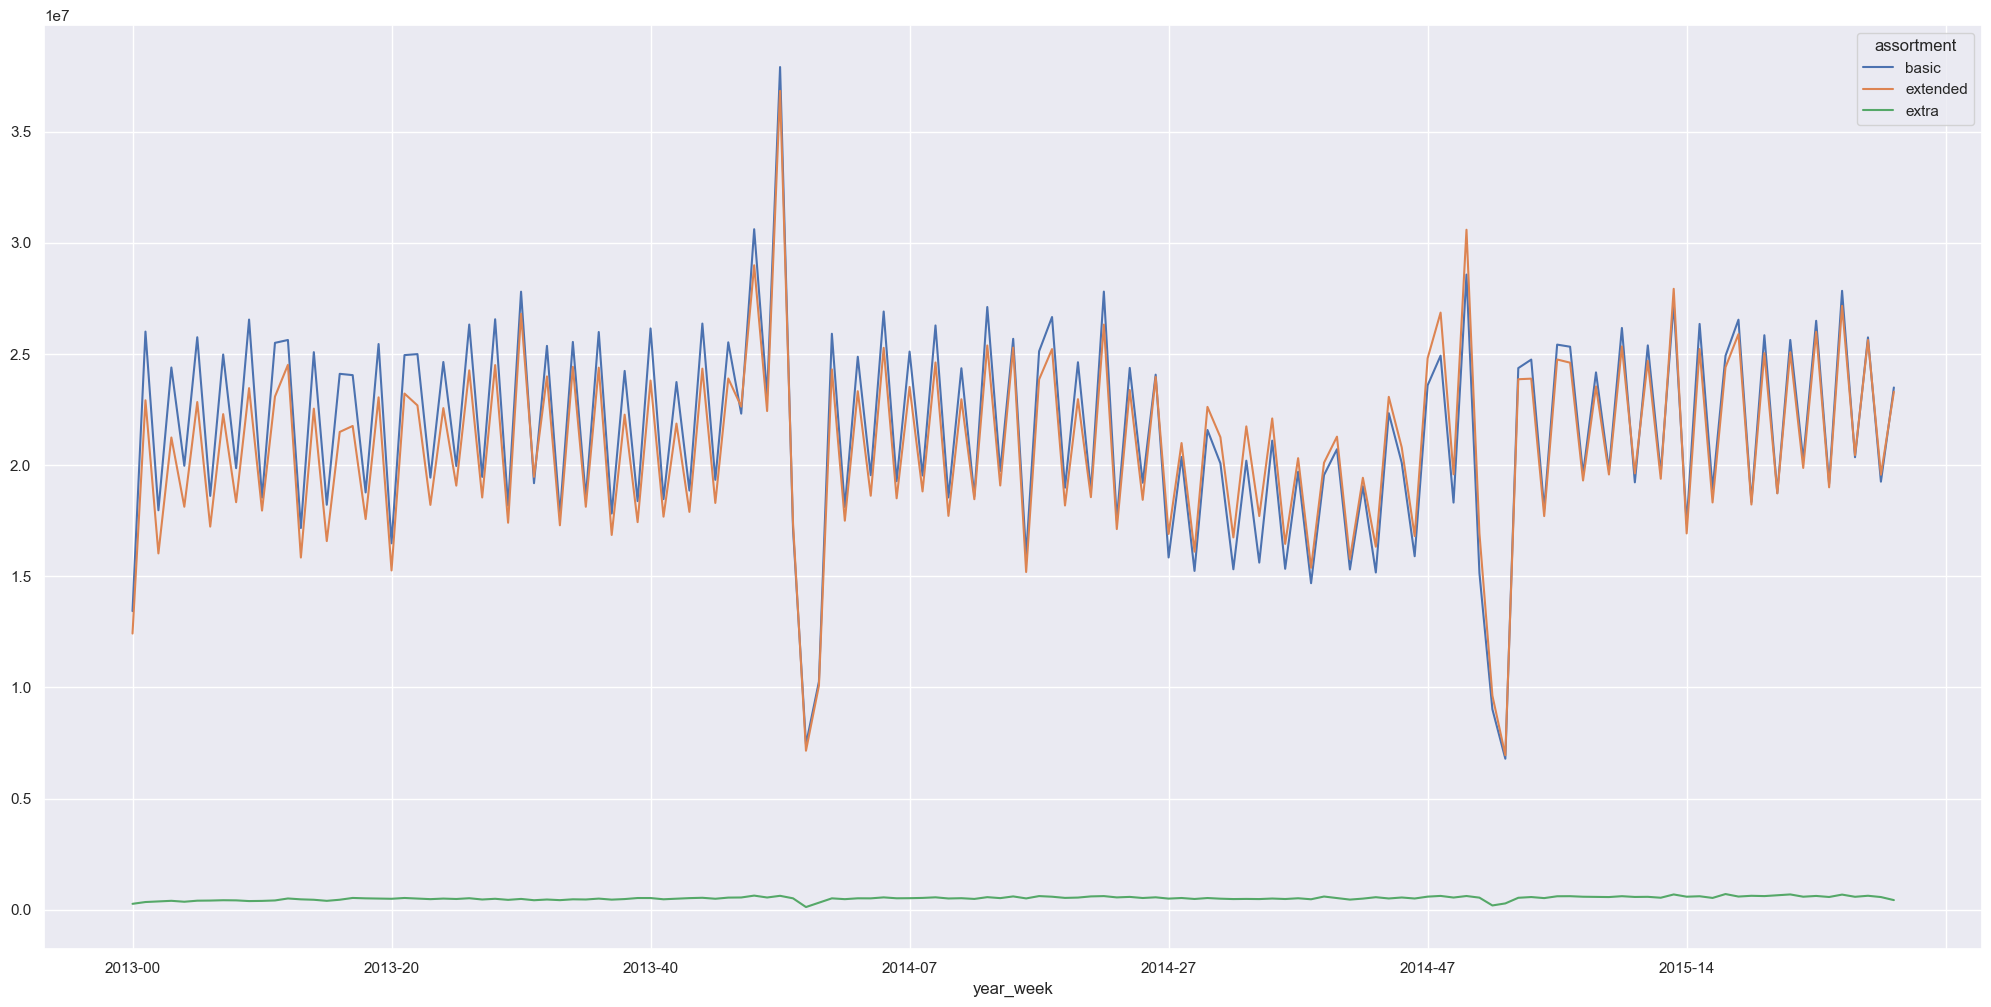

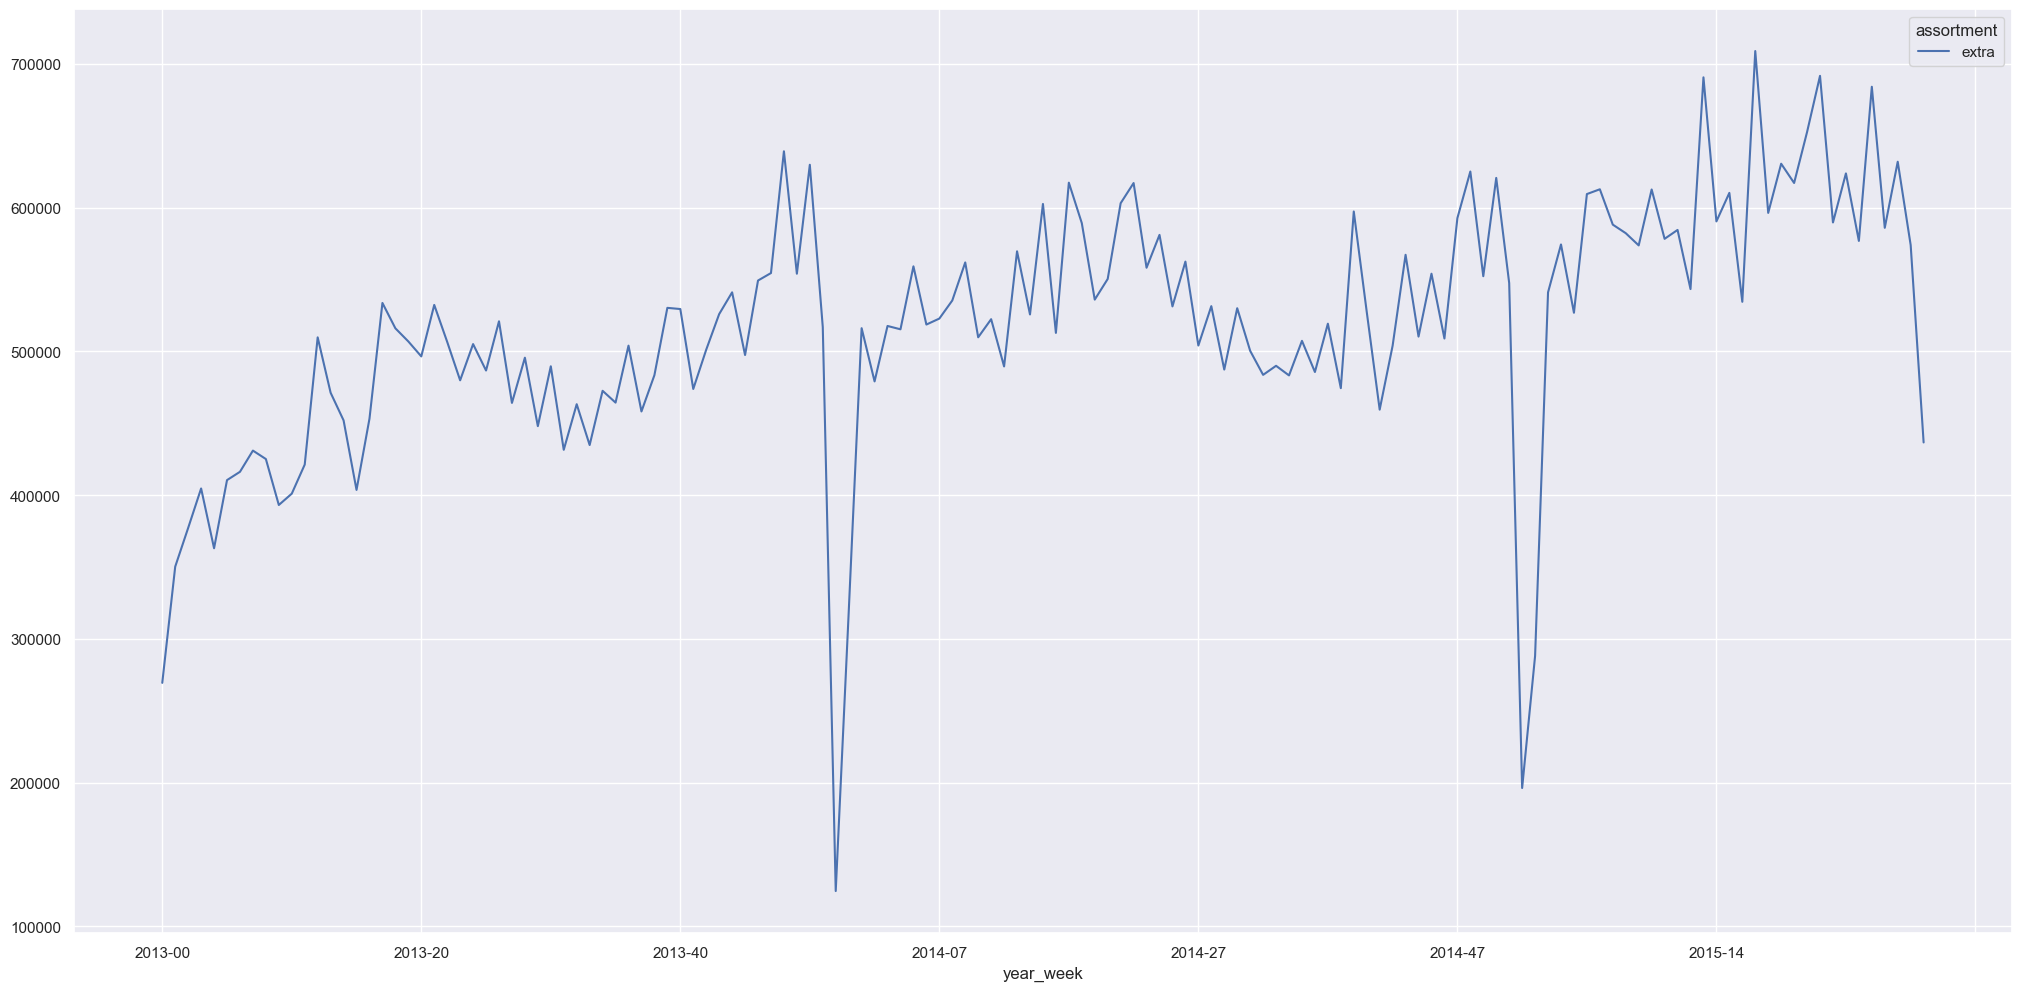

In [ ]:
df_aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot(data=df_aux1, x='assortment', y='sales')

df_aux2 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week', 'assortment']).sum().reset_index()
df_aux2.pivot(index='year_week', columns='assortment', values='sales').plot()

df_aux3 = df_aux2[df_aux2['assortment'] == 'extra']
df_aux3.pivot(index='year_week', columns='assortment', values='sales').plot()

### H2. Lojas com competidores mais próximos deveriam vender menos.
**FALSO** Lojas com COMPETIDORES MAIS PRÓXIMOS vendem MAIS.

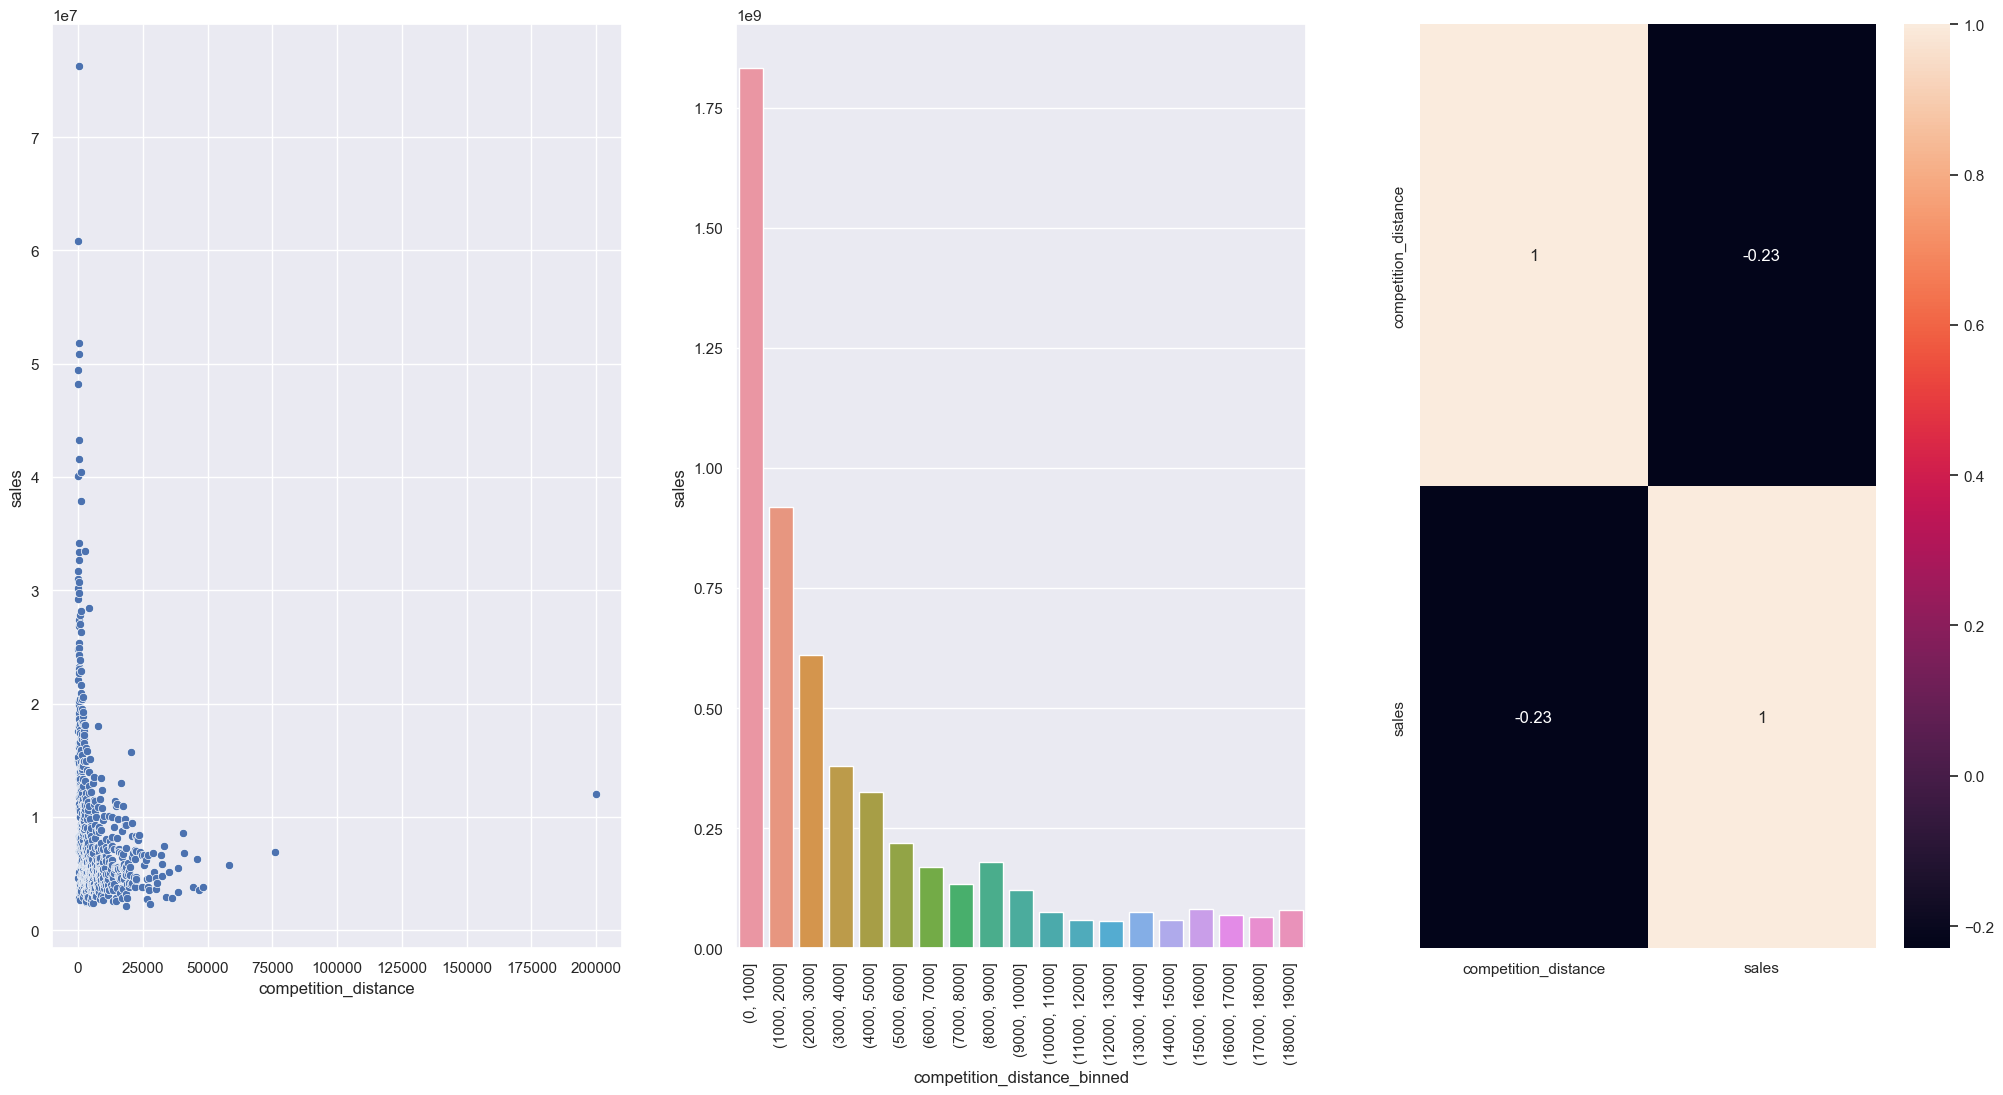

In [ ]:
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

plt.subplot(1, 3, 1)
sns.scatterplot(data=aux1, x='competition_distance', y='sales')

plt.subplot(1, 3, 2)
bins = list(range(0, 20000, 1000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins)
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot(data=aux2, x='competition_distance_binned', y='sales');
plt.xticks(rotation=90)

plt.subplot(1, 3, 3)
sns.heatmap(aux1[['competition_distance', 'sales']].corr(method='pearson'), annot=True);
# bottom, top = x.get_ylim()
# x.set_ylim(bottom+0.5, top-0.5)

### H3. Lojas com competidores há mais tempo deveriam vender mais.
**FALSO** Lojas com competidores há MAIS TEMPO vendem MENOS.

In [ ]:
plt.sublot(1,3,1)
aux1 = df4[['competition_time_month', 'sales']].groupby('competiton_tie_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0)]
sns.barplot(data=aux2, x='competition_time_month', y='sales')
plt.xticks(rotation=90);

plt.sublot(1,3,2)
sns.regplot(data=aux2, x='competition_time_month', y='sales')

plt.subplot(1, 3, 3)
sns.heatmap(aux1[['competition_time_month', 'sales']].corr(method='pearson'), annot=True)

### H4. Lojas com promoções ativas por mais tempo deveriam vender mais.
**FALSO** Lojas com promoções ativas por mais tempo vendem menos, depois de um certo período de promoção

#### Observações
promo_time_week = `data_atual - data_futura`

Períodos de promoção: tradicional ou extendido

1. promo_time_week <font style='color:green'>positivo</font>: período extendido de promoção
2. promo_time_week <font style='color:red'>negativo</font>: período tradicional de promoção


<Axes: >

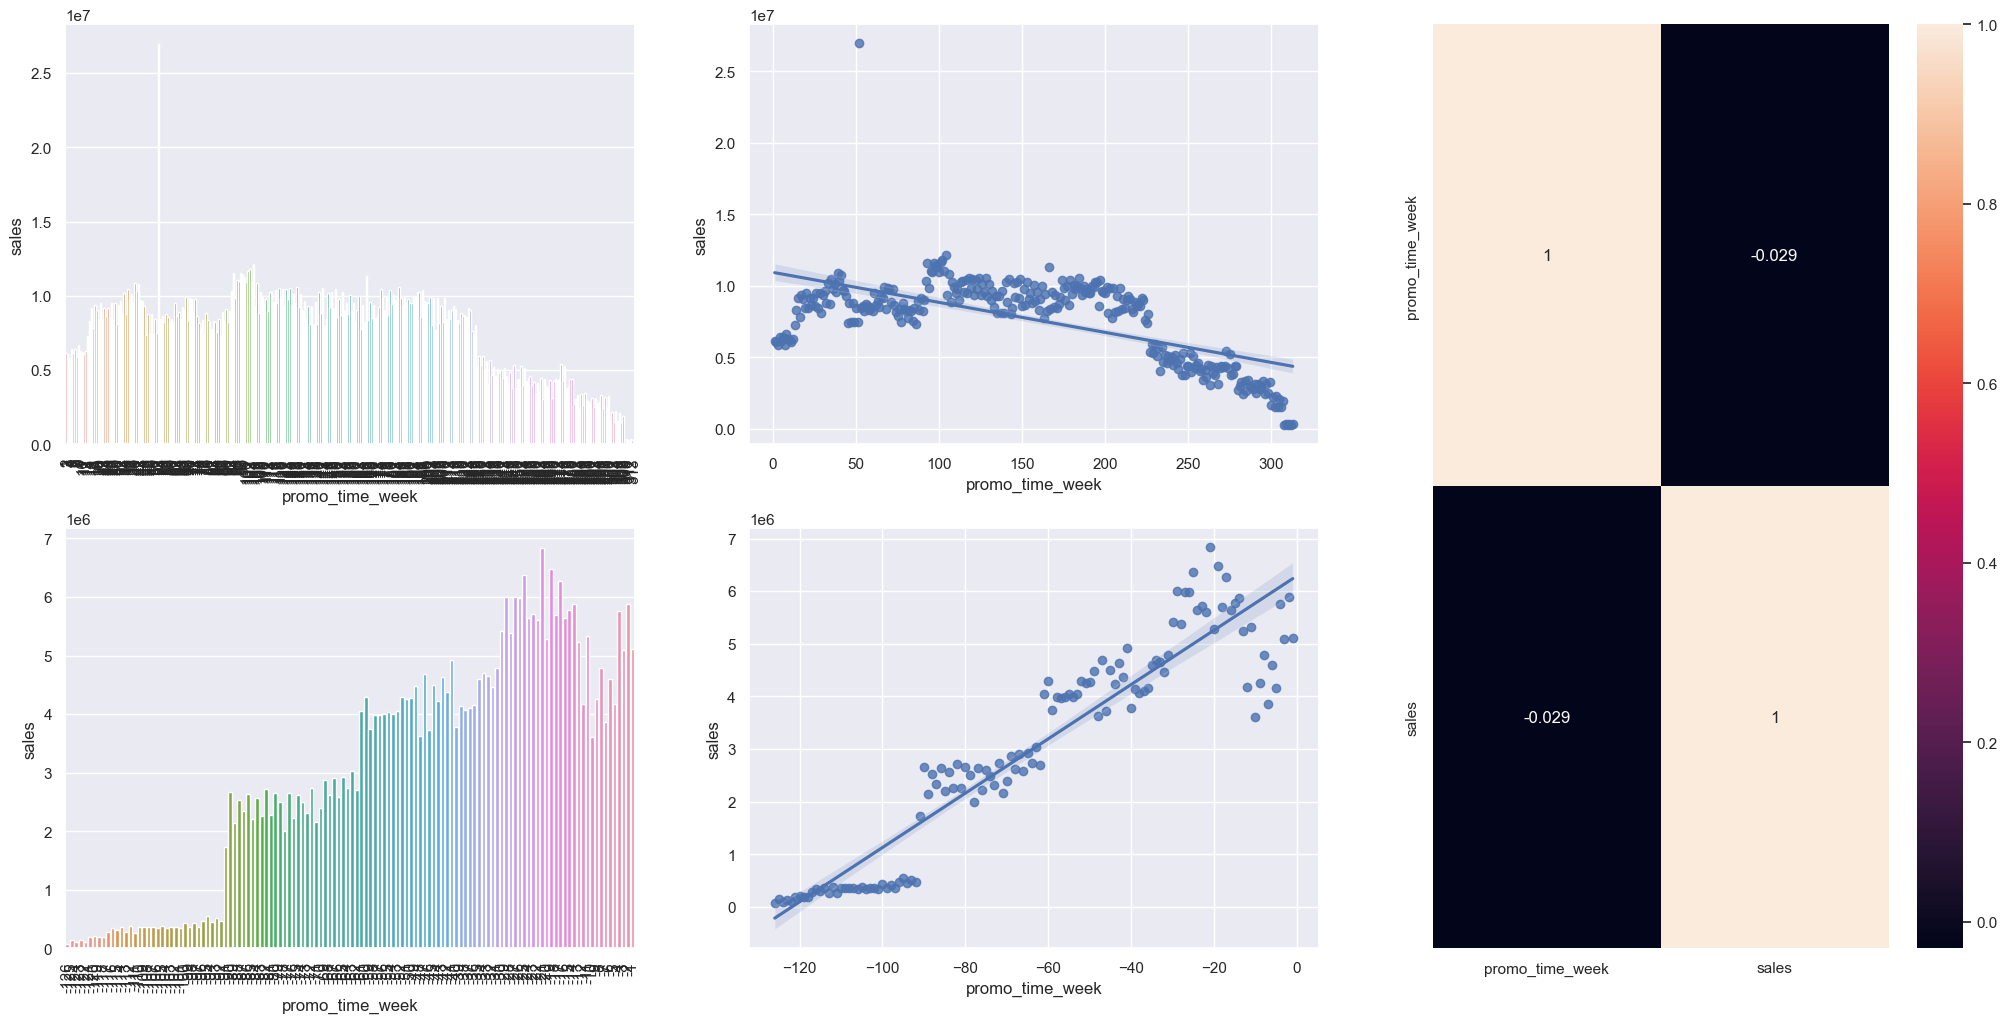

In [ ]:
aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()

grid = gs.GridSpec(2,3)

plt.subplot(grid[0,0])
aux2 = aux1[aux1['promo_time_week'] > 0] # periodo extendido
sns.barplot(data=aux2, x='promo_time_week', y='sales');
plt.xticks(rotation=90)

plt.subplot(grid[0,1])
sns.regplot(data=aux2, x='promo_time_week', y='sales');

plt.subplot(grid[1,0])
aux3 = aux1[aux1['promo_time_week'] < 0] # periodo regular
sns.barplot(data=aux3, x='promo_time_week', y='sales');
plt.xticks(rotation=90);

plt.subplot(grid[1,1])
sns.regplot(data=aux3, x='promo_time_week', y='sales');

plt.subplot(grid[:,2])
sns.heatmap(aux1.corr(method='pearson'), annot=True)

### <s>H5. Lojas com mais dias de promoção deveriam vender mais.</s>

### H7. Lojas com mais promoções consecutivas deveriam vender mais.
**FALSO** Lojas com MAIS promoções consecutivas VENDEM MENOS

In [ ]:
df4[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


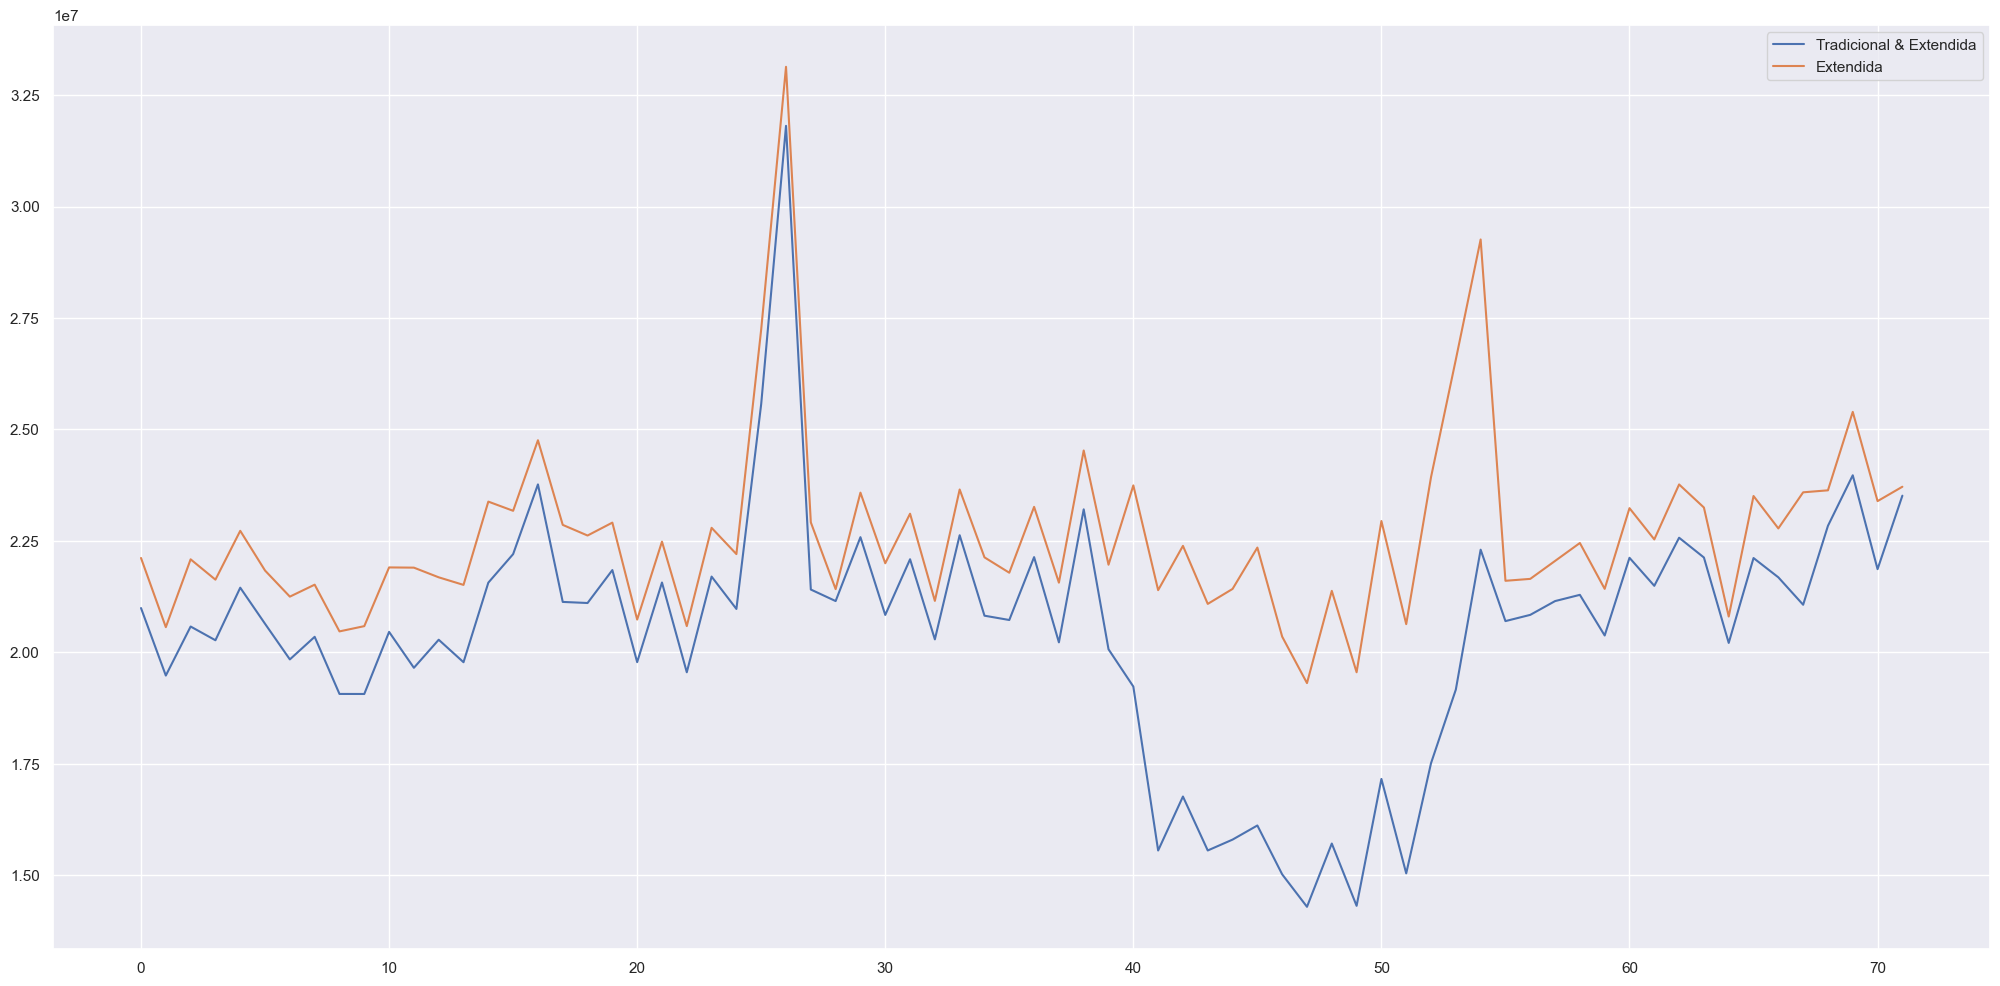

In [ ]:
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot()

aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax=ax)

ax.legend(labels=['Tradicional & Extendida', 'Extendida']);

### H8. Lojas abertas durante o feriado de natal deveriam vender mais
**FALSA** Lojas abertas durante o feriado do natal vendem MENOS

<Axes: xlabel='year', ylabel='sales'>

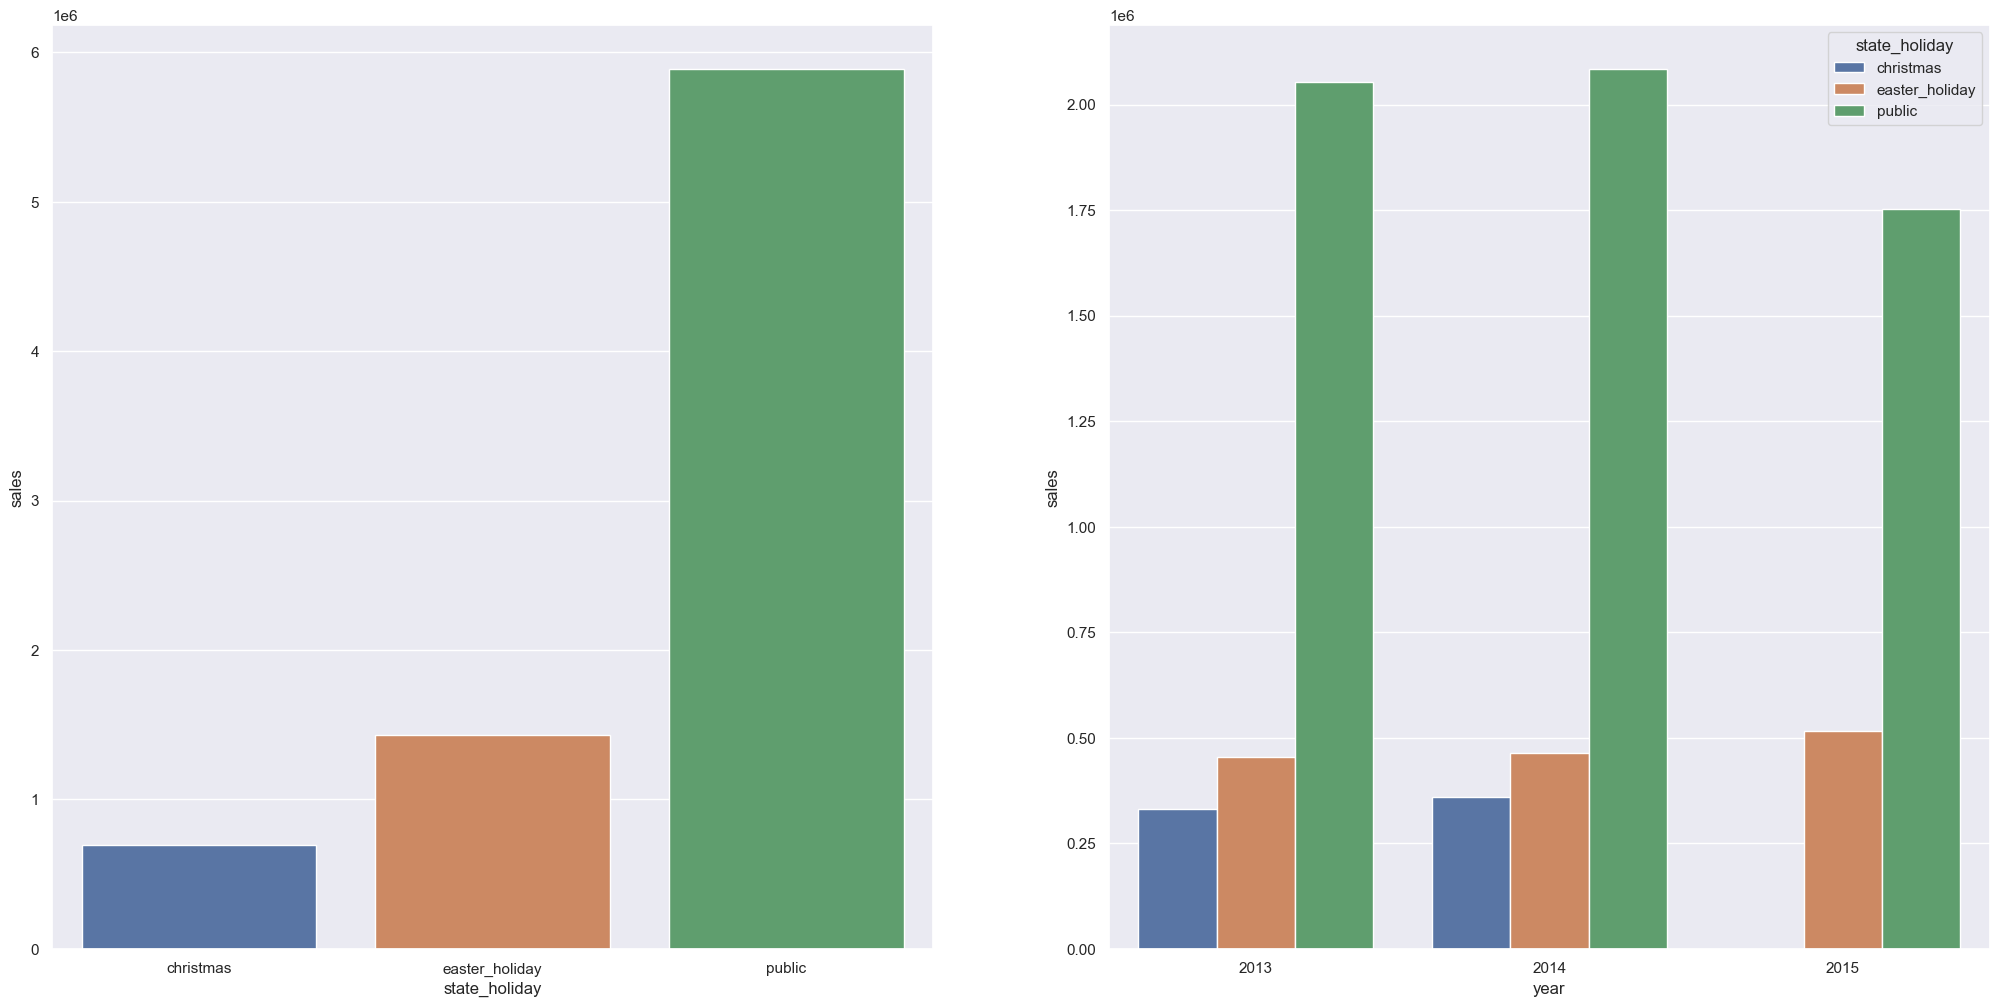

In [ ]:
aux = df4[df4['state_holiday'] != 'regular_day']

plt.subplot(1,2,1)
aux1 = aux[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(data=aux1, x='state_holiday', y='sales')

plt.subplot(1,2,2)
aux2 = aux[['year', 'state_holiday', 'sales']].groupby(['year', 'state_holiday']).sum().reset_index()
sns.barplot(data=aux2, x='year', y='sales', hue='state_holiday')

### H9. Lojas deveriam vender mais ao longo dos anos
**FALSA** Lojas vendem MENOS ao longo dos anos

<Axes: >

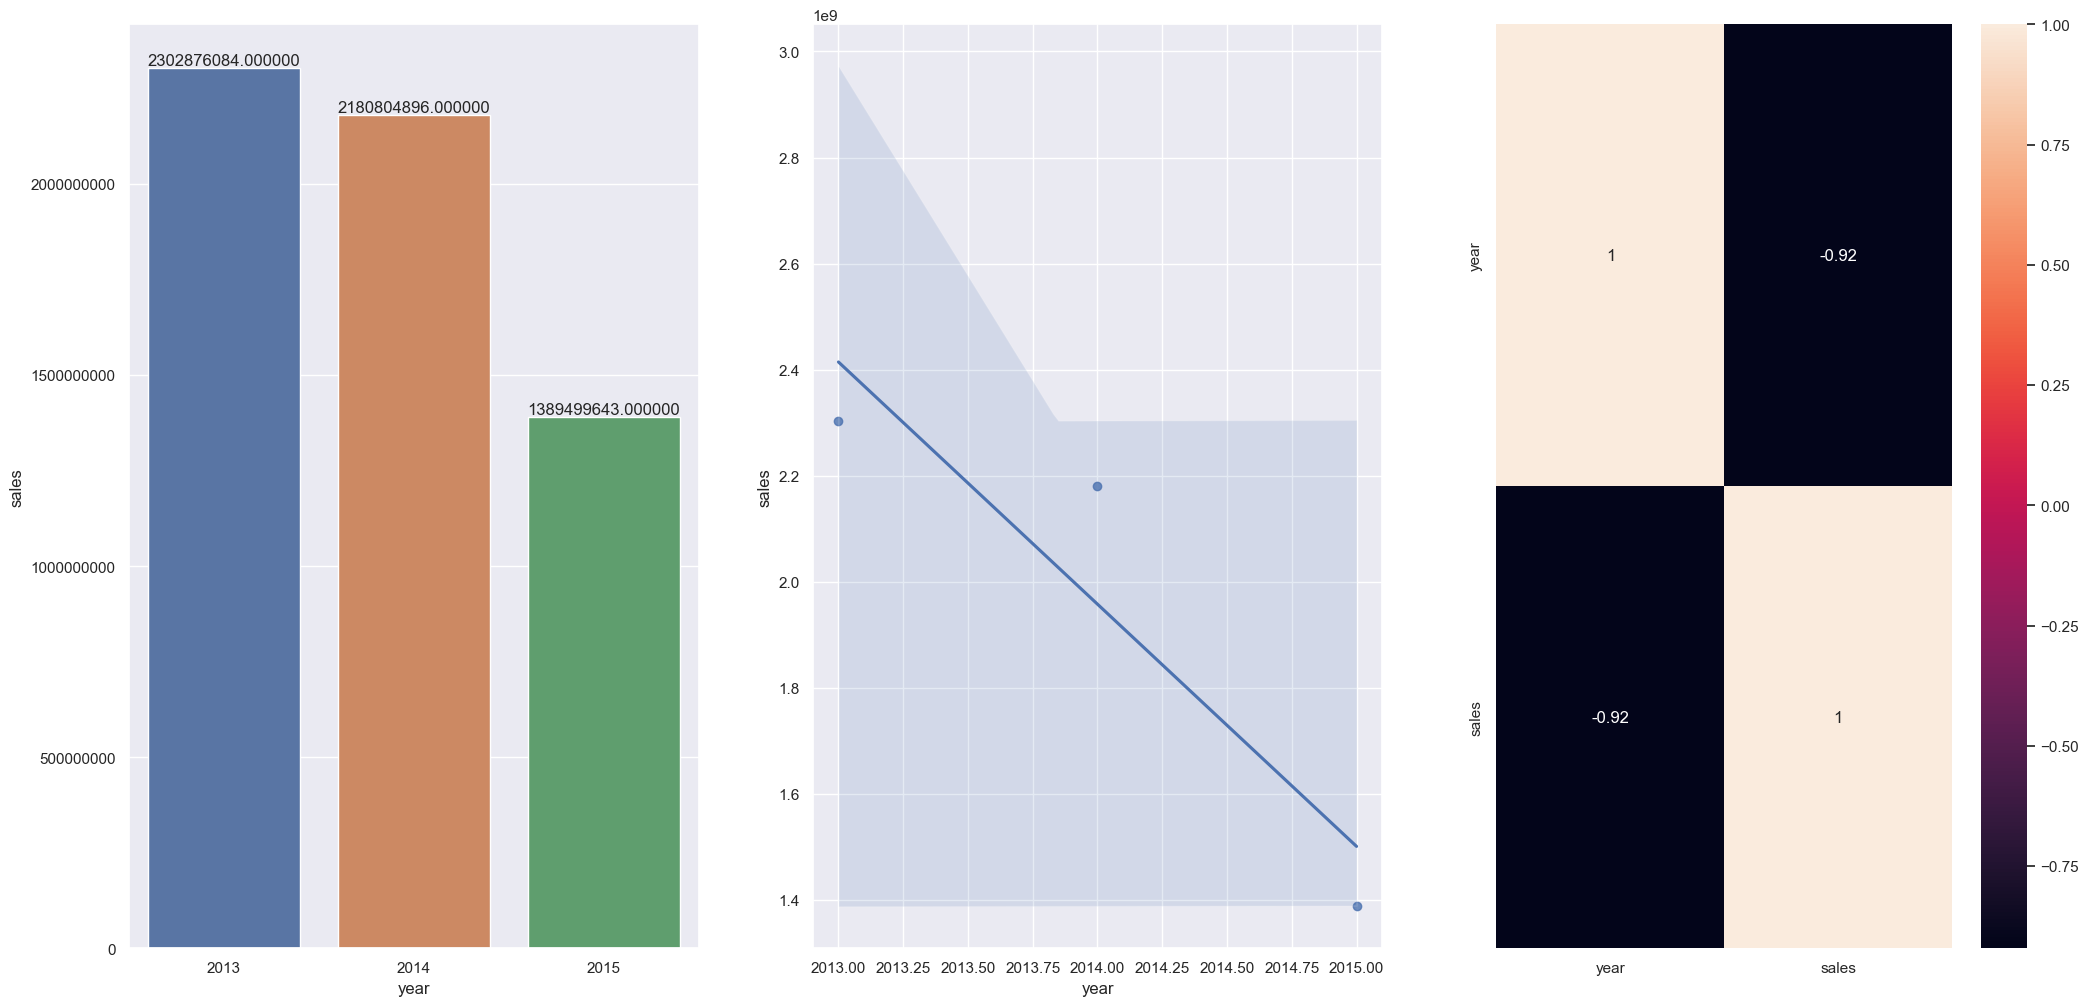

In [ ]:
aux1 = df4[['year', 'sales']].groupby('year').sum().reset_index()

plt.subplot(1,3,1)
plt.ticklabel_format(style='plain')
ax = sns.barplot(data=aux1, x='year', y='sales')
ax.bar_label(ax.containers[0], fmt='%4f')

plt.subplot(1,3,2)
sns.regplot(data=aux1, x='year', y='sales')

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)

### H10. Lojas deveriam vender mais no segundo semestre do ano
**FALSA** Lojas vendem MENOS no segundo semestre do ano

<Axes: >

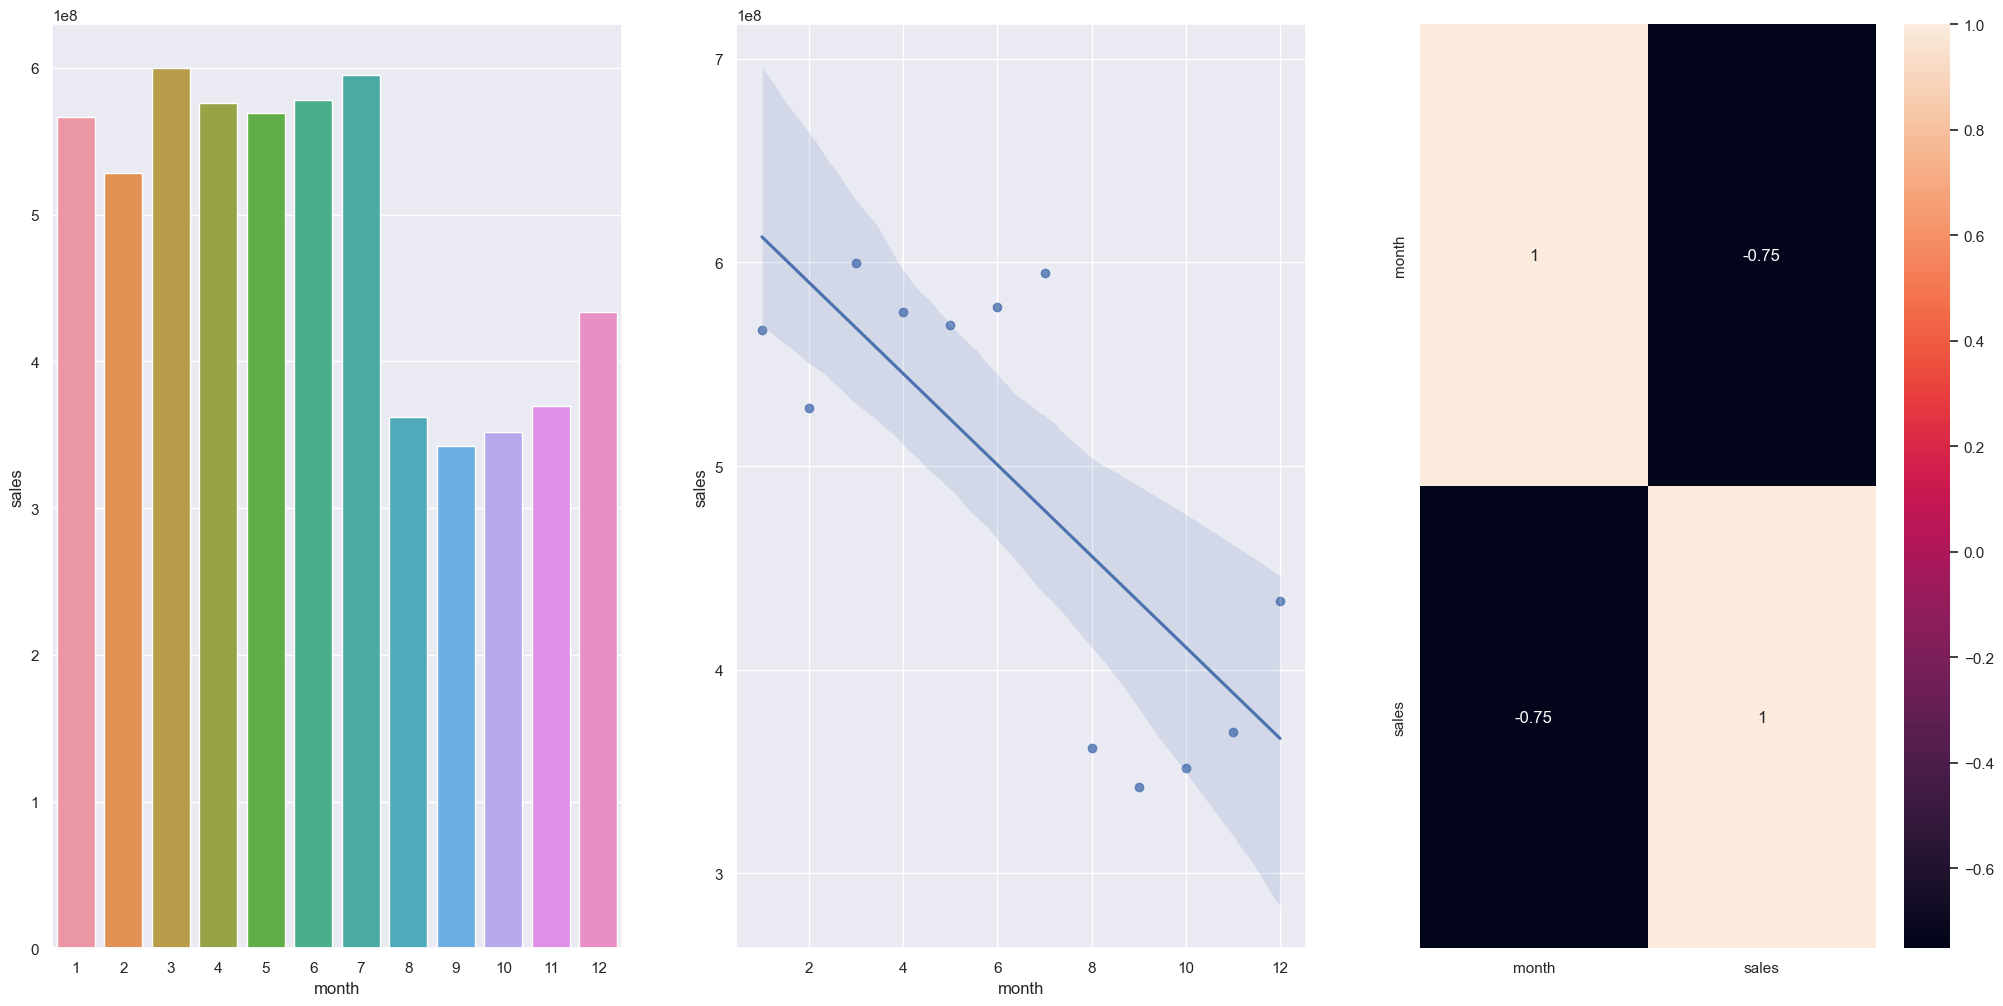

In [ ]:
aux1 = df4[['month', 'sales']].groupby('month').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(data=aux1, x='month', y='sales')

plt.subplot(1,3,2)
sns.regplot(data=aux1, x='month', y='sales')

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)

### H11. Lojas deveriam vender mais depois do dia 10 de cada mês
**VERDADEIRA** Lojas vendem mais após o dia 10 de cada mês

[Text(0, 0, '3902775310.000000'), Text(0, 0, '1970405313.000000')]

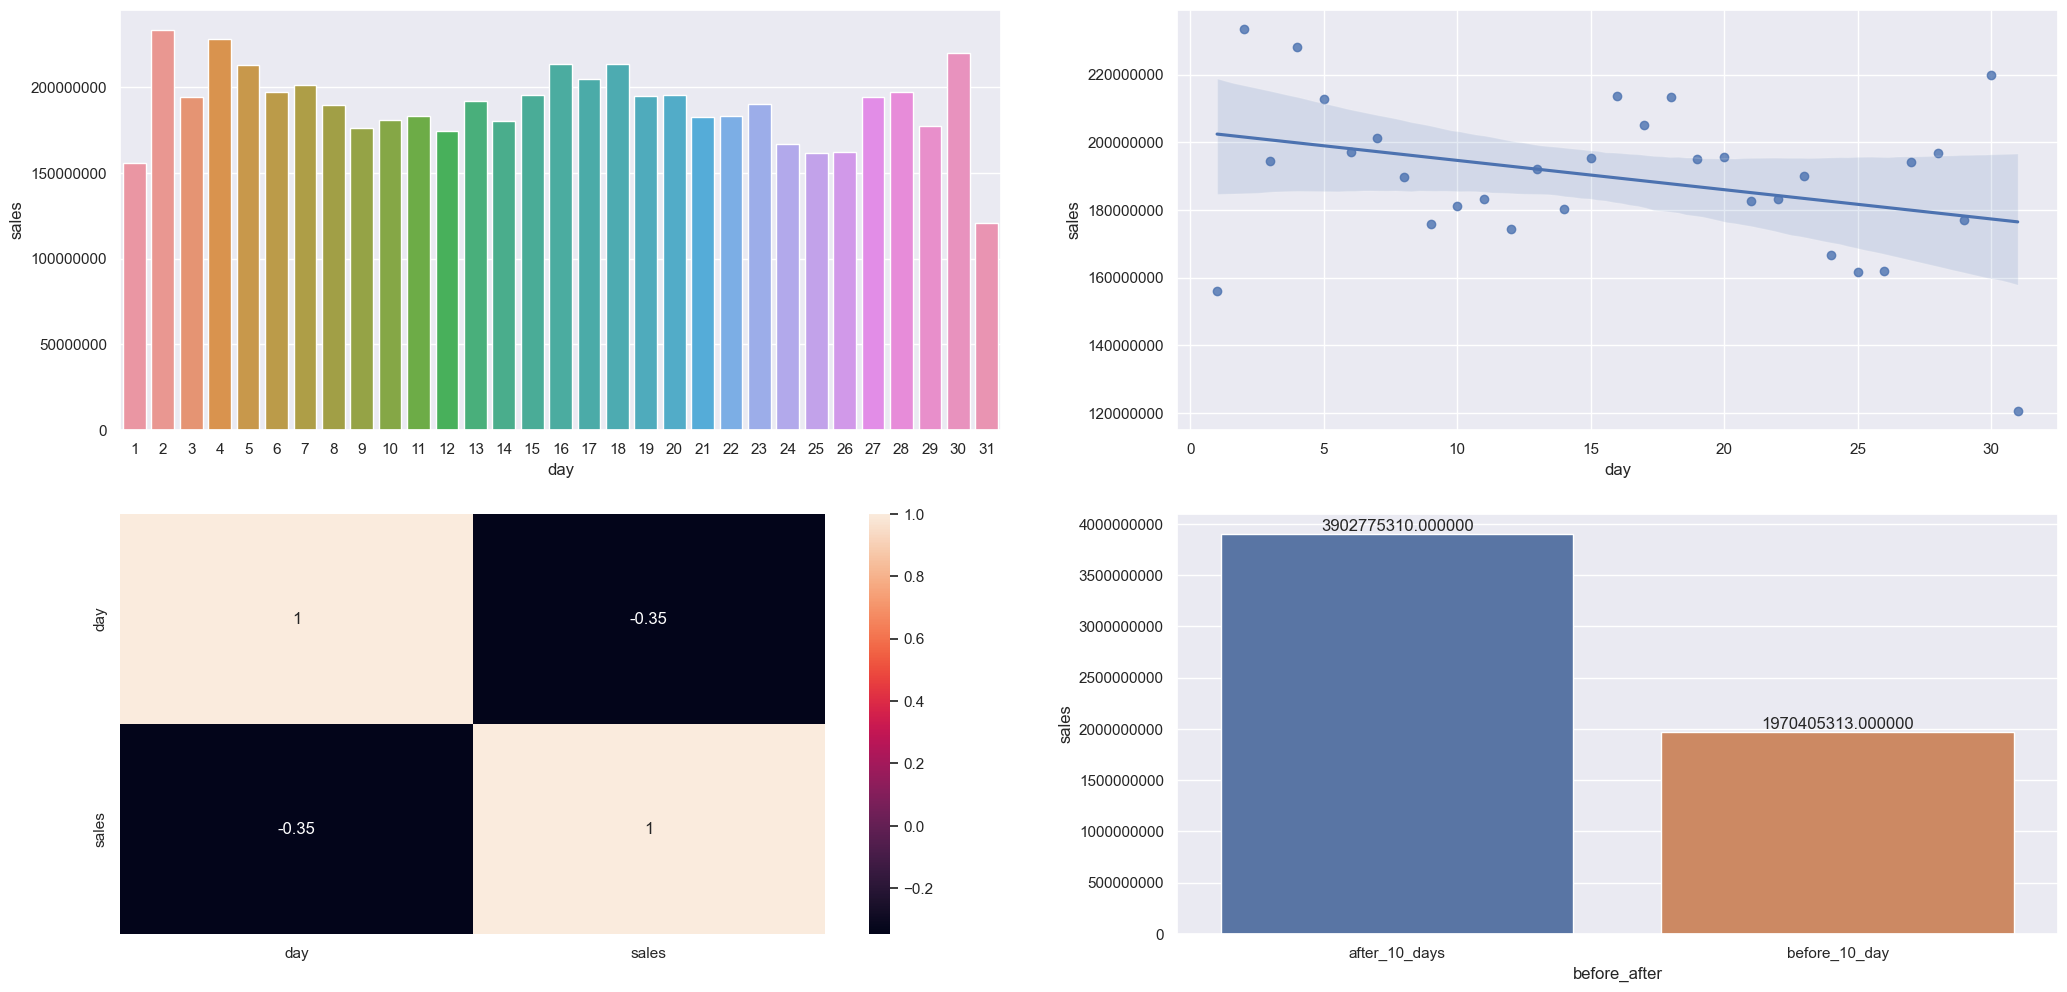

In [ ]:
sns.set_theme(rc={'axes.formatter.limits': (-5, 10)})

aux1 = df4[['day', 'sales']].groupby('day').sum().reset_index()

plt.subplot(2,2,1)
sns.barplot(data=aux1, x='day', y='sales')

plt.subplot(2,2,2)
sns.regplot(data=aux1, x='day', y='sales')

plt.subplot(2,2,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)

aux1['before_after'] = aux1['day'].apply(lambda x: 'before_10_day' if x <= 10 else 'after_10_days')
aux2 = aux1[['before_after', 'sales']].groupby('before_after').sum().reset_index()

plt.subplot(2,2,4)
ax = sns.barplot(data=aux2, x='before_after', y='sales')


### H12. Lojas deveriam vender menos aos finais de semana
**VERDADEIRA** Lojas vendem MENOS nos finais de semana

<Axes: >

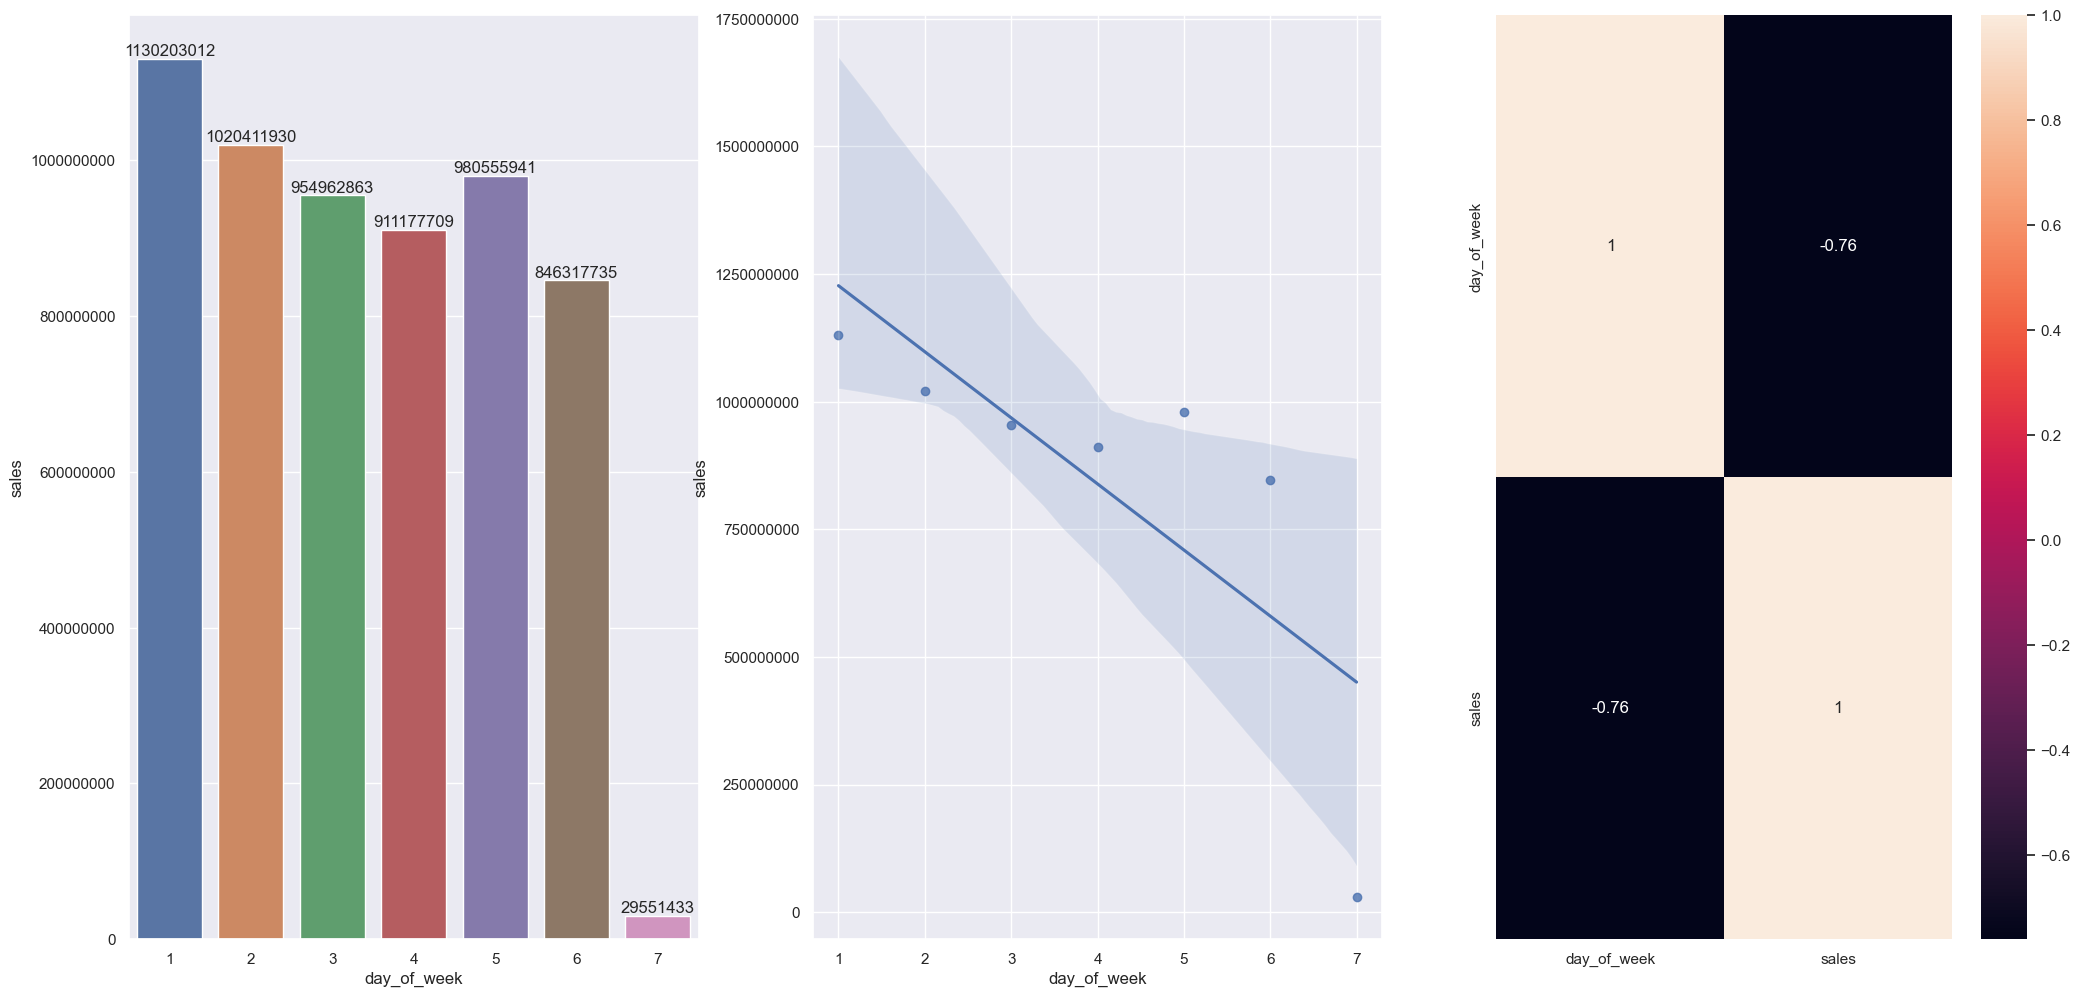

In [ ]:
aux1 = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()

plt.subplot(1,3,1)
ax = sns.barplot(data=aux1, x='day_of_week', y='sales')
ax.bar_label(ax.containers[0], fmt='%d')

plt.subplot(1,3,2)
sns.regplot(data=aux1, x='day_of_week', y='sales')

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)

### H13. Lojas deveriam vender menos durante feriados escolares
**VERDADEIRA** Lojas vendem menos durante os feriados escolares, exceto os meses de julho e agosto

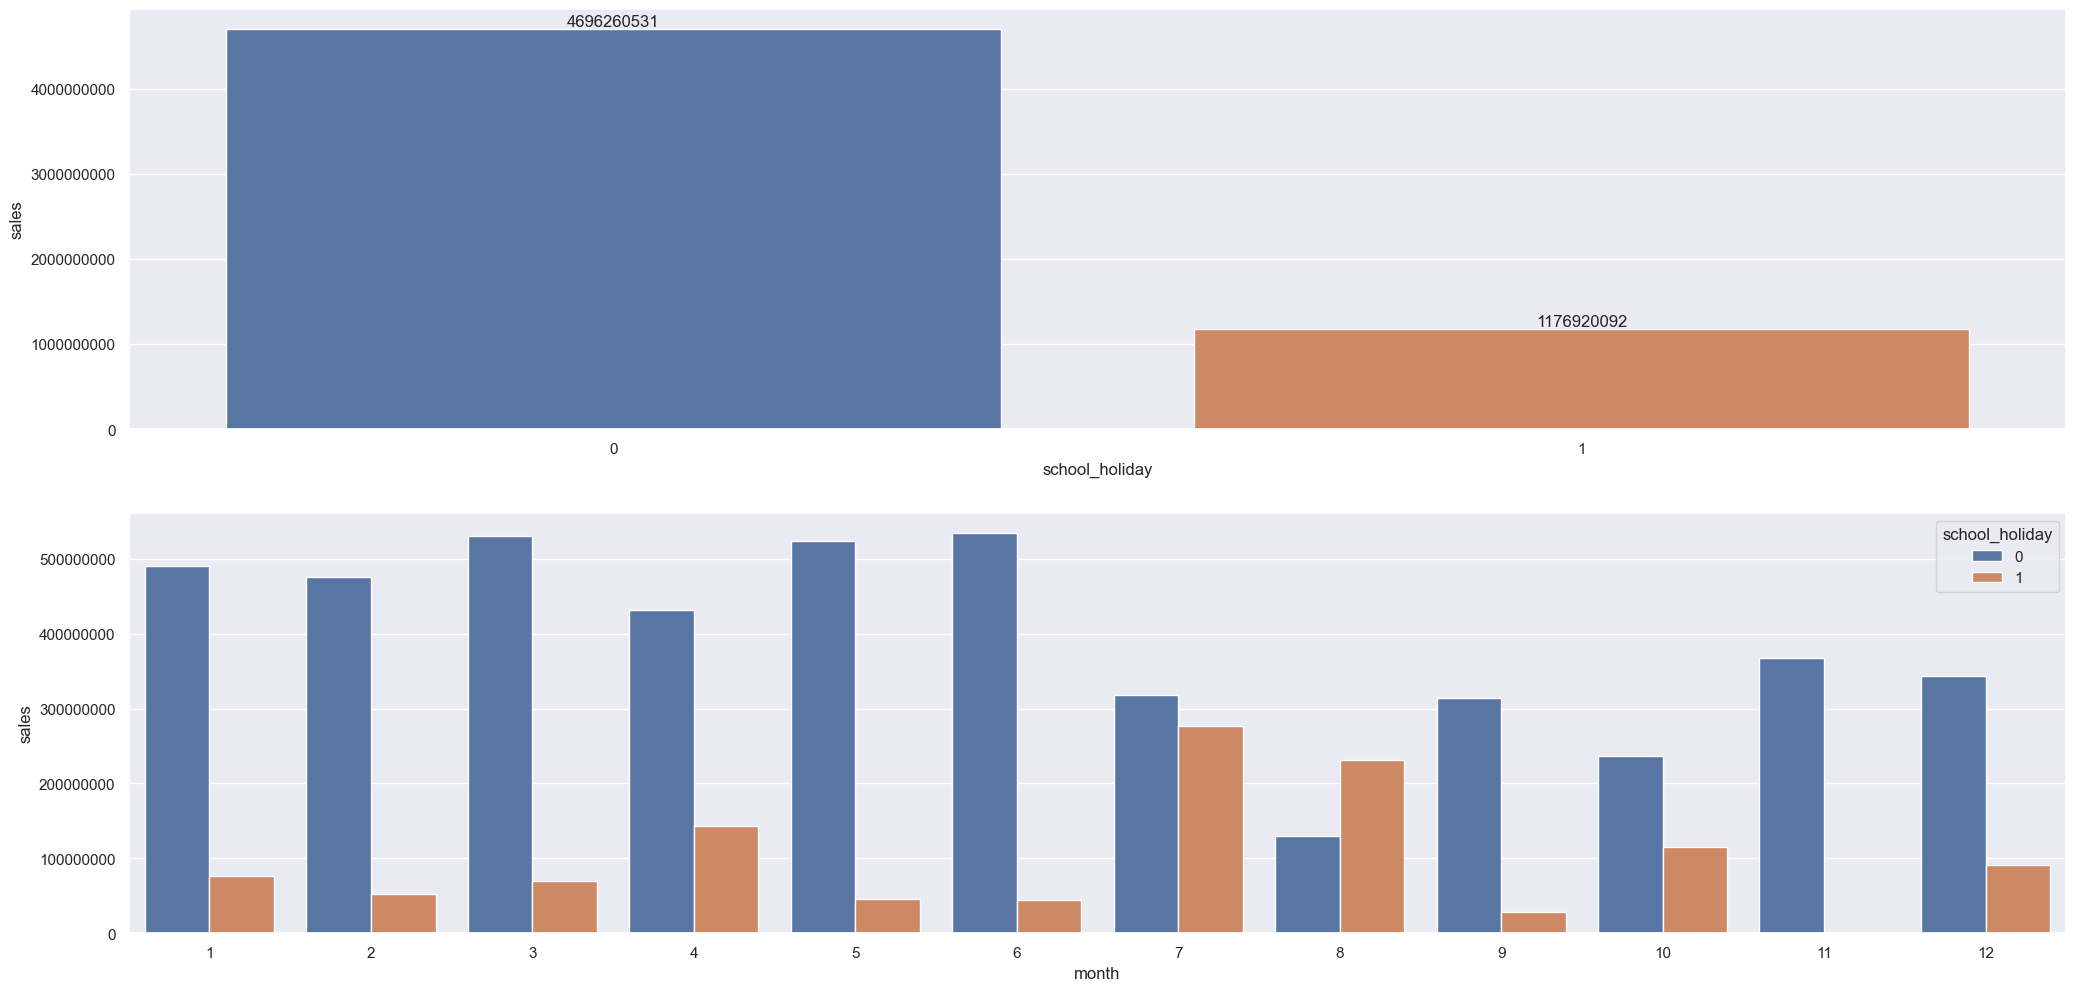

In [ ]:
aux1 = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()

plt.subplot(2,1,1)
ax = sns.barplot(data=aux1, x='school_holiday', y='sales')
ax.bar_label(ax.containers[0], fmt='%d');

plt.subplot(2,1,2)
aux1 = df4[['month', 'school_holiday', 'sales']].groupby(['month', 'school_holiday']).sum().reset_index()
sns.barplot(data=aux1, x='month', y='sales', hue='school_holiday');

### 4.2.1 Resumo de Hipóteses

| Hipóteses | Conclusão | Relevância |
| :-- | :-- | :-- |
| 'H1' | Falsa | Baixa | 
| 'H2' | Falsa | Média | 
| 'H3' | Falsa | Média | 
| 'H4' | Falsa | Baixa | 
| 'H5' | - | - | 
| 'H7' | Falsa | Média | 
| 'H8' | Falsa | Média | 
| 'H9' | Falsa | Alta | 
| 'H10' | Falsa | Alta | 
| 'H11' | Verdadeira | Alta | 
| 'H12' | Verdadeira | Alta | 
| 'H13' | Verdadeira | Baixa | 

## 4.3 Análise Multivariada

### 4.3.1 Atributos numéricos

Legenda:

    1. Quanto mais perto do preto maior a correlação negativa
    2. Quanto mais perto do branco maior a correlação positiva

<Axes: >

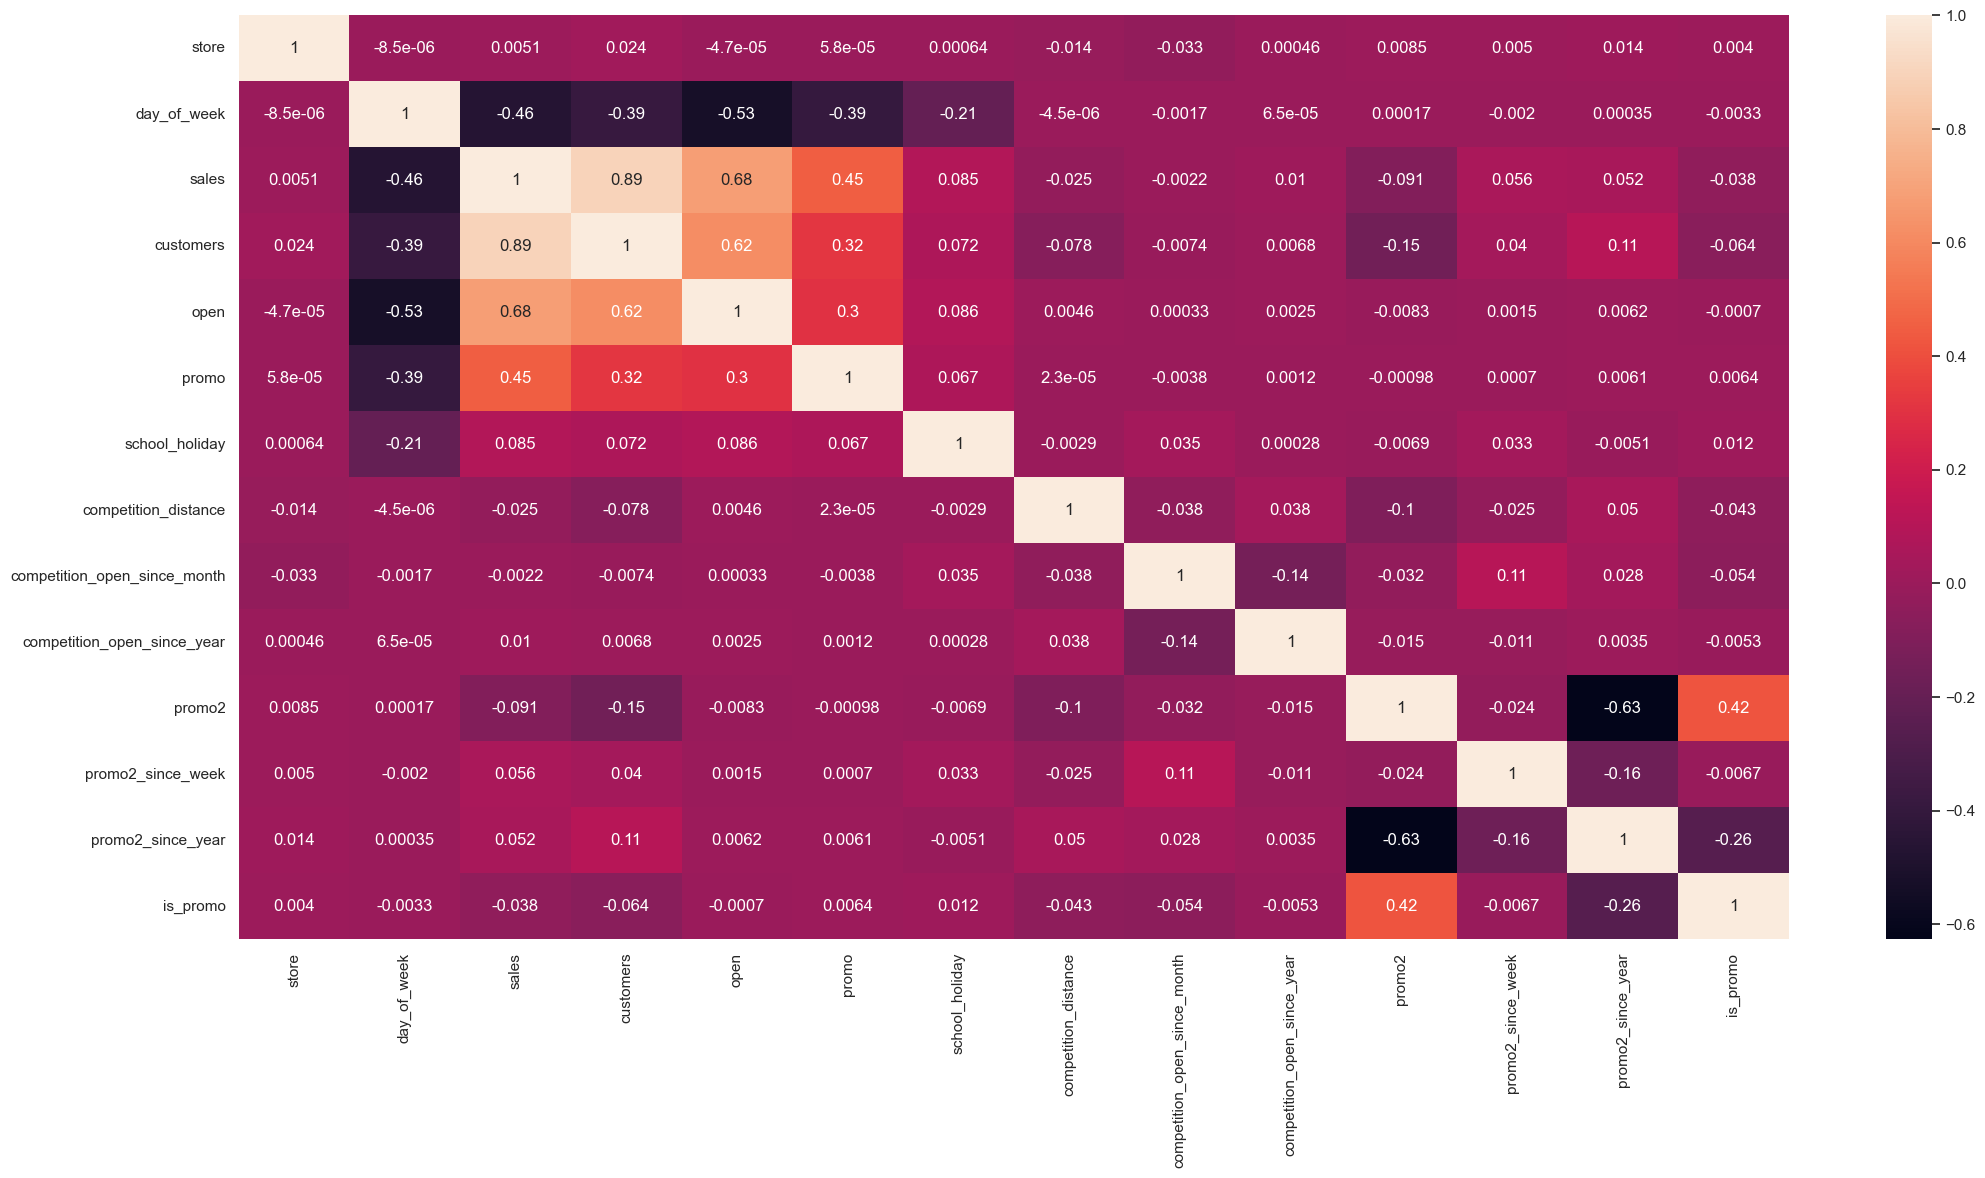

In [ ]:
correlacao = num_attributes.corr(method='pearson')
sns.heatmap(correlacao, annot=True)

### 4.3.2 Atributos categóricos

In [ ]:
# apenas dados categóricos
ca = df4.select_dtypes(include='object')

# calculando o cramer V
a1 = cramer_v(ca['state_holiday'], ca['state_holiday'])
a2 = cramer_v(ca['state_holiday'], ca['store_type'])
a3 = cramer_v(ca['state_holiday'], ca['assortment'])

a4 = cramer_v(ca['store_type'], ca['state_holiday'])
a5 = cramer_v(ca['store_type'], ca['store_type'])
a6 = cramer_v(ca['store_type'], ca['assortment'])

a7 = cramer_v(ca['assortment'], ca['state_holiday'])
a8 = cramer_v(ca['assortment'], ca['store_type'])
a9 = cramer_v(ca['assortment'], ca['assortment'])

# criando dataframe final
d = pd.DataFrame( {'state_holiday': [a1, a2, a3],
                    'store_type': [a4, a5, a6],
                    'assortment': [a7, a8, a9]})

d = d.set_index(d.columns)

<Axes: >

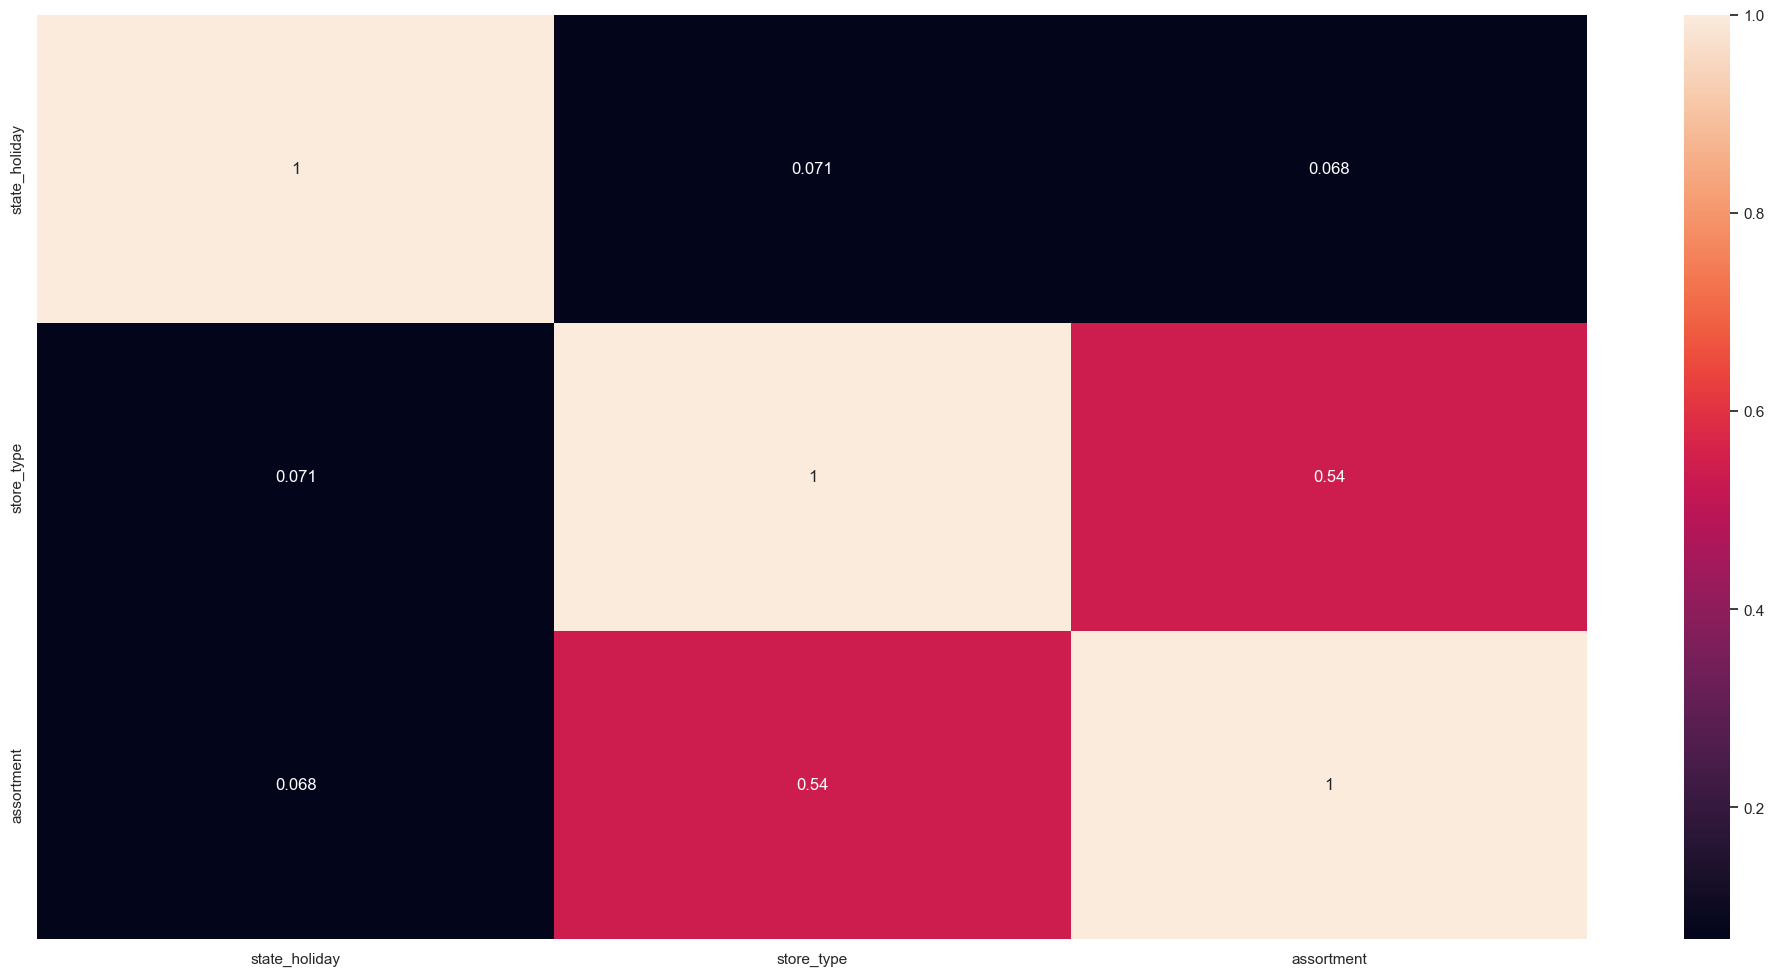

In [ ]:
sns.heatmap(d, annot=True)

# 5.0 Preparacao dos Dados

In [ ]:
df4 = pickle.load(open('../datasets/interim/pkl/03_filtragem_variaveis.pkl', 'rb'))

In [ ]:
df5 = df4.copy()
df5.head()

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,...,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,1,regular_day,1,c,basic,1270.0,...,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,1,regular_day,1,a,basic,570.0,...,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,1,regular_day,1,a,basic,14130.0,...,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1,regular_day,1,c,extended,620.0,...,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,1,regular_day,1,a,basic,29910.0,...,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


## 5.1 Normalização

Não há dados com a distribuição normal
> A distribuição normal é uma distribuição de probabilidade contínua e simétrica em ambos os lados da média, de modo que o lado direito é uma imagem espelhada do esquerdo. É a mais familiar das distribuições de probabilidade e também uma das mais importantes em estatística.

## 5.2 Rescaling

In [ ]:
resc = df5.select_dtypes(include=['int64', 'float64'])

<Axes: xlabel='year', ylabel='store'>

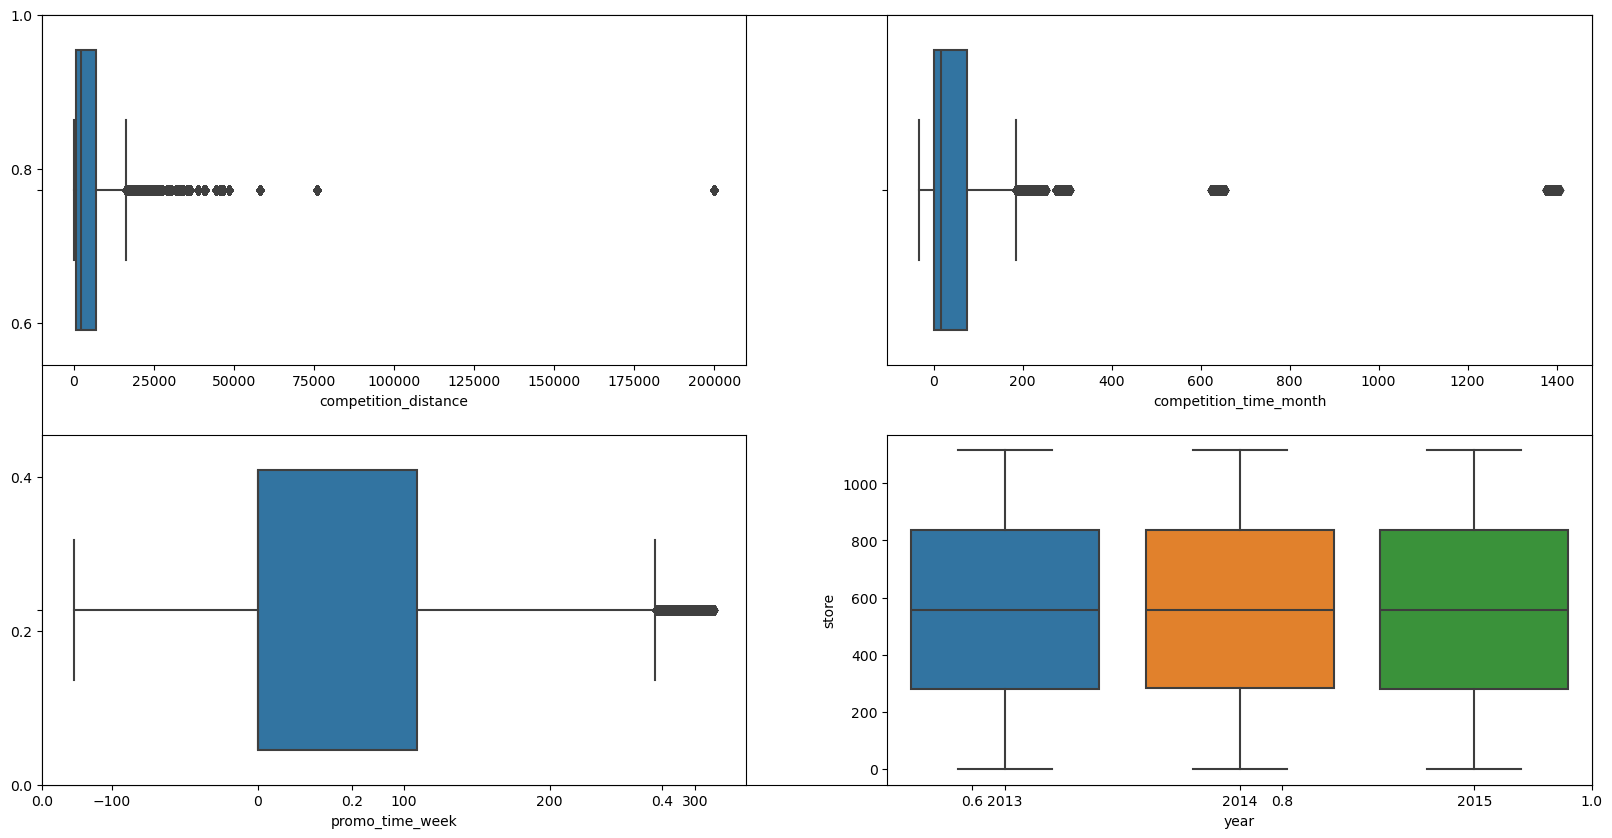

In [ ]:
figure = plt.subplots(figsize=(20,10))

plt.subplot(2,2,1)
sns.boxplot(x=df5['competition_distance'])

plt.subplot(2,2,2)
sns.boxplot(x=df5['competition_time_month'])

plt.subplot(2,2,3)
sns.boxplot(x=df5['promo_time_week'])

plt.subplot(2,2,4)
sns.boxplot(x=df5['year'], y=df5['store'])

In [ ]:
rs = RobustScaler()
mms = MinMaxScaler()

# # competition distance
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)

# # competition time month
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)

# # promo time week
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)

# year
df5['year'] = mms.fit_transform(df5[['year']].values)

c:\Users\garri\anaconda3\envs\ds_producao\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


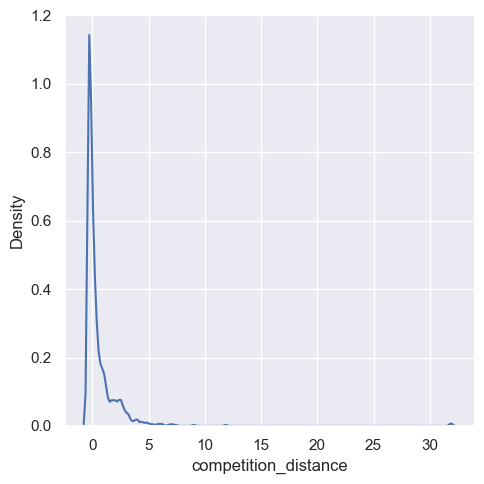

In [ ]:
sns.displot(x=df5['competition_distance'], kind='kde');

## 5.3 Transformação

### 5.3.1 Encoding

In [ ]:
# state_holiday - One Hot Encoding
df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])

# store_type - Label Encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])

# assortment - Ordinal Encoding
assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
df5['assortment'] = df5['assortment'].map(assortment_dict)


### 5.3.2 Transformação da Variável Resposta

In [ ]:
df5['sales'] = np.log1p(df5['sales'])

### 5.3.3 Transformação de Natureza

In [ ]:
# day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin( x * (2. * np.pi/7)))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos( x * (2. * np.pi/7)))

# month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin( x * (2. * np.pi/12)))
df5['month_cos'] = df5['month'].apply(lambda x: np.cos( x * (2. * np.pi/12)))

# day
df5['day_sin'] = df5['day'].apply(lambda x: np.sin( x * (2. * np.pi/30)))
df5['day_cos'] = df5['day'].apply(lambda x: np.cos( x * (2. * np.pi/30)))

# week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin( x * (2. * np.pi/52)))
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos( x * (2. * np.pi/52)))


# 6.0 Selecao de Variaveis

In [ ]:
df6 = pickle.load(open('../datasets/interim/pkl/05_preparacao_dados.pkl', 'rb'))

## 6.1 Divisão do dataframe em treino e teste
1. Excluir variáveis originais, ou seja, variáveis que originaram outras variáveis.

In [4]:
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week']
df6 = df6.drop(cols_drop, axis=1)

In [5]:
df6[['store', 'date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta(days=6*7)

Timestamp('2015-06-19 00:00:00')

In [6]:
# Dataset de Treino
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

# Dataset de Teste
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

print(f'Treino Min Data {X_train["date"].min()}')
print(f'Treino Max Data {X_train["date"].max()}')

print(f'\nTest Min Data {X_test["date"].min()}')
print(f'Test Max Data {X_test["date"].max()}')

Treino Min Data 2013-01-01 00:00:00
Treino Max Data 2015-06-18 00:00:00

Test Min Data 2015-06-19 00:00:00
Test Max Data 2015-07-31 00:00:00


## 6.2 Boruta como seletor de variáveis

In [ ]:
# treinamento e teste do dataset para boruta
# ravel = Colocar em um vetor []

X_train_n = X_train.drop(['date', 'sales'], axis=1).values
y_train_n = y_train.values.ravel()

# # Definindo RandomForestRegressor
rf = RandomForestRegressor(n_jobs=-1)

# Definindo boruta
boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42).fit(X_train_n, y_train_n)

### 6.2.1 Melhores colunas selecionadas pelo Boruta

In [ ]:
cols_selecionadas = boruta.support_.tolist()

# Melhores colunas
X_train_fs = X_train.drop(['date', 'sales'], axis=1)
cols_selecionadas_boruta = X_train_fs.iloc[:, cols_selecionadas].columns.tolist()

# Colunas não selecionadas Boruta
cols_nao_selecionadas_boruta = list(np.setdiff1d(X_train_fs.columns, cols_selecionadas_boruta))

In [ ]:
cols_selecionadas_boruta

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'day_of_week_sin',
 'day_of_week_cos',
 'month_cos',
 'day_sin',
 'day_cos',
 'week_of_year_cos']

In [ ]:
cols_nao_selecionadas_boruta

['is_promo',
 'month_sin',
 'school_holiday',
 'state_holiday_christmas',
 'state_holiday_easter_holiday',
 'state_holiday_public',
 'state_holiday_regular_day',
 'week_of_year_sin',
 'year']

## 6.3 Selecao Manual de Colunas de Acordo com o Boruta

In [7]:
colunas_selecionadas_boruta = ['store', 'promo',
                                'store_type', 'assortment',
                                'competition_distance', 'competition_open_since_month',
                                'competition_open_since_year', 'promo2',
                                'promo2_since_week', 'promo2_since_year',
                                'competition_time_month', 'promo_time_week',
                                'day_of_week_sin', 'day_of_week_cos',
                                'month_cos', 'day_sin',
                                'day_cos', 'week_of_year_cos']

# # colunas para adicionar
cols_adicionar = ['date', 'sales']

# # conjunto de colunas final
colunas_selecionadas_boruta_completo = colunas_selecionadas_boruta.copy()
colunas_selecionadas_boruta_completo.extend(cols_adicionar)

# 7.0 Machine Learning

In [9]:
# Colunas utilizadas no treino e teste
x_train = X_train[colunas_selecionadas_boruta]
x_test = X_test[colunas_selecionadas_boruta]

# Colunas utilizads no cross validation
x_training = X_train[colunas_selecionadas_boruta_completo]

## 7.1 Average Model

In [14]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

aux2 = aux1[['store', 'sales']].groupby('store').mean().reset_index().rename(columns = {'sales': 'predictions'})
aux1 = pd.merge(aux1, aux2, how='left', on='store')
yhat_baseline = aux1['predictions']

baseline_result = ml_error('Average Model', np.expm1(y_test), np.expm1(yhat_baseline) )
baseline_result

,Modelo,MAE,MAPE,RMSE
0,Average Model,1354.80,0.21,1835.14


## 7.2 Linear Regression

In [15]:
# Definição e Treinamento
lr = lm.LinearRegression().fit(x_train, y_train)

# Perfomance
yhat_lr = lr.predict(x_test)

lr_result = ml_error('Linear Regressor', np.expm1(y_test), np.expm1(yhat_lr))
lr_result

,Modelo,MAE,MAPE,RMSE
0,Linear Regressor,1869.92,0.30,2667.52


### 7.2.1 Cross Validation: Regressão Linear 

In [16]:
lr_result_cv = cross_validation(x_training, 5, 'Linear Regression', lr, verbose=False)
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2079.28 +/- 303.04,0.3 +/- 0.02,2961.07 +/- 473.32


## 7.3 Linear Regression Regularized - Lasso

In [17]:
# Definição e Treinamento
lrr = lm.Lasso(alpha = 0.01).fit(x_train, y_train)

# Perfomance
yhat_lrr = lrr.predict(x_test)

lrr_result = ml_error('Lasso', np.expm1(y_test), np.expm1(yhat_lrr))
lrr_result

,Modelo,MAE,MAPE,RMSE
0,Lasso,1891.19,0.29,2741.00


### 7.3.1 Cross Validation: Linear Regression - Lasso

In [18]:
lrr_result_cv = cross_validation(x_training, 5, 'Lasso', lrr, verbose=False)
lrr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,2116.98 +/- 342.05,0.29 +/- 0.01,3059.41 +/- 504.65


## 7.4 Random Forest Regressor

In [19]:
# Definição e Treinamento
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42).fit(x_train, y_train)

# Predição
yhat_rf = rf.predict(x_test)

# Perfomance
rf_result = ml_error('Random Forest Regressor', np.expm1(y_test), np.expm1(yhat_rf))
rf_result

,Modelo,MAE,MAPE,RMSE
0,Random Forest Regressor,731.14,0.11,1075.68


### 7.4.1 Cross Validation: Random Forest Regressor

In [20]:
rf_result_cv = cross_validation(x_training, 5, 'Random Forest Regressor', rf, verbose=False)
rf_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,841.13 +/- 222.99,0.12 +/- 0.02,1259.45 +/- 327.53


## 7.5 Regressão XGBoost

In [10]:
# Definição e Treinamento
modelo_xgb = xgb.XGBRegressor(objective='reg:squarederror',
                             n_estimators=1000,
                             eta=0.01,
                             max_depth=10,
                             subsample=0.7,
                             colsample_bytree=0.9).fit(x_train, y_train)

# Predição
yhat_xgb = modelo_xgb.predict(x_test)

# Perfomance
xgb_result = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb))
xgb_result

,Modelo,MAE,MAPE,RMSE
0,XGBoost Regressor,885.34,0.13,1298.86


### 7.5.1 Cross Validation: XGBoost Regressor

In [11]:
xgb_result_cv = cross_validation(x_training, 5, 'XGBoost Regression', modelo_xgb, verbose=False)
xgb_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regression,1039.3 +/- 157.91,0.14 +/- 0.01,1506.64 +/- 221.66


## 7.6 Comparação da Perfomance dos Modelos

### 7.6.1 Perfomance Simples

In [ ]:
modelos_result = pd.concat([baseline_result, lr_result, lrr_result, rf_result, xgb_result])
modelos_result.sort_values('RMSE')

### 7.6.2 Perfomance Real (Cross Validation)

In [ ]:
modelos_result = pd.concat([lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv])
modelos_result.sort_values('RMSE CV')

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,841.13 +/- 222.99,0.12 +/- 0.02,1259.45 +/- 327.53
0,Linear Regression,2079.28 +/- 303.04,0.3 +/- 0.02,2961.07 +/- 473.32
0,Lasso,2116.98 +/- 342.05,0.29 +/- 0.01,3059.41 +/- 504.65
0,XGBoost Regression,7049.28 +/- 588.36,0.95 +/- 0.0,7715.35 +/- 689.12


# 8. Fine Tuning Hyperparameters

## 8.1 Random Search

In [12]:
param = {
        'n_estimators': [1500, 1700, 2500, 3000, 3500],
        'eta': [0.01, 0.03],
        'max_depth': [3 ,5, 9],
        'subsample': [0.1, 0.5, 0.7],
        'colsample_bytree': [0.3, 0.5, 0.9],
        'min_child_weight': [3, 8, 15]
}

MAX_EVAL = 10

In [13]:
final_result = pd.DataFrame()

for i in range(MAX_EVAL):
    
    # Escolha aleatoria dos parametros
    hp = { k: random.sample (v, 1)[0] for k, v in param.items() }
    print(hp)
    
    # Definição e Treinamento
    modelo_xgb = xgb.XGBRegressor(objective='reg:squarederror',
                                    n_estimators=hp['n_estimators'], 
                                    eta=hp['eta'],
                                    max_depth=hp['max_depth'],
                                    subsample=hp['subsample'],
                                    colsample_bytree=hp['colsample_bytree'],
                                    min_child_weight=hp['min_child_weight']
                                    )

    # Perfomance
    result = cross_validation(x_training, 2, 'XGBoost Regressor', modelo_xgb, verbose=True)
    final_result = pd.concat([final_result, result])
    
final_result

{'n_estimators': 1700, 'eta': 0.03, 'max_depth': 9, 'subsample': 0.7, 'colsample_bytree': 0.5, 'min_child_weight': 15}
KFold Number: 2
KFold Number: 1
{'n_estimators': 3000, 'eta': 0.01, 'max_depth': 5, 'subsample': 0.7, 'colsample_bytree': 0.5, 'min_child_weight': 15}
KFold Number: 2
KFold Number: 1
{'n_estimators': 2500, 'eta': 0.03, 'max_depth': 9, 'subsample': 0.5, 'colsample_bytree': 0.9, 'min_child_weight': 3}
KFold Number: 2
KFold Number: 1
{'n_estimators': 3500, 'eta': 0.01, 'max_depth': 9, 'subsample': 0.5, 'colsample_bytree': 0.5, 'min_child_weight': 3}
KFold Number: 2
KFold Number: 1
{'n_estimators': 3500, 'eta': 0.03, 'max_depth': 3, 'subsample': 0.1, 'colsample_bytree': 0.5, 'min_child_weight': 15}
KFold Number: 2
KFold Number: 1
{'n_estimators': 3500, 'eta': 0.03, 'max_depth': 5, 'subsample': 0.1, 'colsample_bytree': 0.9, 'min_child_weight': 8}
KFold Number: 2
KFold Number: 1
{'n_estimators': 2500, 'eta': 0.03, 'max_depth': 9, 'subsample': 0.7, 'colsample_bytree': 0.9, 'm

,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,807.96 +/- 88.51,0.11 +/- 0.01,1184.07 +/- 166.03
0,XGBoost Regressor,1278.31 +/- 68.19,0.17 +/- 0.0,1879.1 +/- 130.6
0,XGBoost Regressor,815.53 +/- 96.91,0.11 +/- 0.01,1191.49 +/- 168.45
0,XGBoost Regressor,836.07 +/- 85.49,0.11 +/- 0.01,1224.71 +/- 165.39
0,XGBoost Regressor,1242.9 +/- 67.79,0.17 +/- 0.0,1799.17 +/- 123.12
0,XGBoost Regressor,912.24 +/- 95.0,0.12 +/- 0.01,1308.82 +/- 165.37
0,XGBoost Regressor,798.35 +/- 98.79,0.11 +/- 0.01,1170.37 +/- 175.05
0,XGBoost Regressor,808.48 +/- 100.63,0.11 +/- 0.01,1180.79 +/- 174.26
0,XGBoost Regressor,1012.38 +/- 67.08,0.13 +/- 0.0,1487.65 +/- 139.59
0,XGBoost Regressor,933.83 +/- 82.89,0.12 +/- 0.01,1368.69 +/- 153.19


## 8.2 Modelo Final

In [14]:
param_tuned = {
        'n_estimators': 3000,
        'eta': 0.03,
        'max_depth': 5,
        'subsample': 0.7,
        'colsample_bytree': 0.7,
        'min_child_weight': 3 
        }

In [15]:
# Definição e Treinamento
modelo_xgb_tuned = xgb.XGBRegressor(objective='reg:squarederror',
                                n_estimators=param_tuned['n_estimators'], 
                                eta=param_tuned['eta'],
                                max_depth=param_tuned['max_depth'],
                                subsample=param_tuned['subsample'],
                                colsample_bytree=param_tuned['colsample_bytree'],
                                min_child_weight=param_tuned['min_child_weight']
                                ).fit(x_train, y_train)

# Predição
yhat_xgb_tuned = modelo_xgb_tuned.predict(x_test)

# Perfomance
final_result_tuned = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb_tuned))
final_result_tuned

,Modelo,MAE,MAPE,RMSE
0,XGBoost Regressor,786.36,0.12,1115.04


In [8]:
modelo_xgb_tuned = pickle.load(open('../datasets/modelos/tuned/modelo_xgb_tuned_pkl.pkl', 'rb'))
yhat_xgb_tuned = pickle.load(open('../datasets/modelos/tuned/yhat_xgb_tuned_pkl.pkl', 'rb'))

# 9. Tradução e Interpretação do Erro

In [48]:
df9 = X_test[colunas_selecionadas_boruta_completo]

In [52]:
# Rescale
df9.loc[:, 'sales'] = np.expm1(df9['sales'])
df9.loc[:, 'predictions'] = np.expm1(yhat_xgb_tuned)

C:\Users\garri\AppData\Local\Temp\ipykernel_6412\1098497895.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9.loc[:, 'predictions'] = np.expm1(yhat_xgb_tuned)


## 9.1 Perfomance em Negócio

In [55]:
# Somar as predições
df91 = df9[['store', 'predictions']].groupby('store').sum().reset_index()

# MAE e MAPE
df9_aux1 = (df9[['store', 'sales', 'predictions']].groupby('store')
                                                  .apply(lambda x: mt.mean_absolute_error(x['sales'], x['predictions']), include_groups=False)
                                                  .reset_index()
                                                  .rename(columns={0: 'MAE'}))

df9_aux2 = (df9[['store', 'sales', 'predictions']].groupby('store')
                                                  .apply(lambda x: mt.mean_absolute_percentage_error(x['sales'], x['predictions']), include_groups=False)
                                                  .reset_index()
                                                  .rename(columns={0: 'MAPE'}))


# Merge
df9_aux3 = pd.merge(df9_aux1, df9_aux2, how='inner', on='store')
df92 = pd.merge(df91, df9_aux3, how='inner', on='store')

# Cenários
df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAPE']

# Ordenando as colunas
df92 = df92[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]

In [56]:
df92.sort_values('MAPE', ascending=False).head()

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
291,292,108699.48,105333.59,108700.09,3365.90,0.60
908,909,227702.23,219932.69,227702.75,7769.54,0.52
901,902,205041.27,203497.12,205041.65,1544.14,0.39
169,170,207886.55,206374.80,207886.92,1511.74,0.38
875,876,195984.23,191873.99,195984.57,4110.25,0.34


In [21]:
# Esse filtro foi feito com base no vídeo, onde o sample mostrado são exatamente esses valores.
# filtro = (df92['store'] == 55) | (df92['store'] == 932) | (df92['store'] == 637) | (df92['store'] == 642)
# df92.loc[filtro, :]

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
54,55,179550.89,179050.05,179551.00,500.84,0.11
636,637,317314.41,316266.18,317314.52,1048.23,0.11
641,642,148606.02,147775.17,148606.27,830.85,0.26
931,932,275299.19,274644.21,275299.28,654.98,0.09


<Axes: xlabel='store', ylabel='MAPE'>

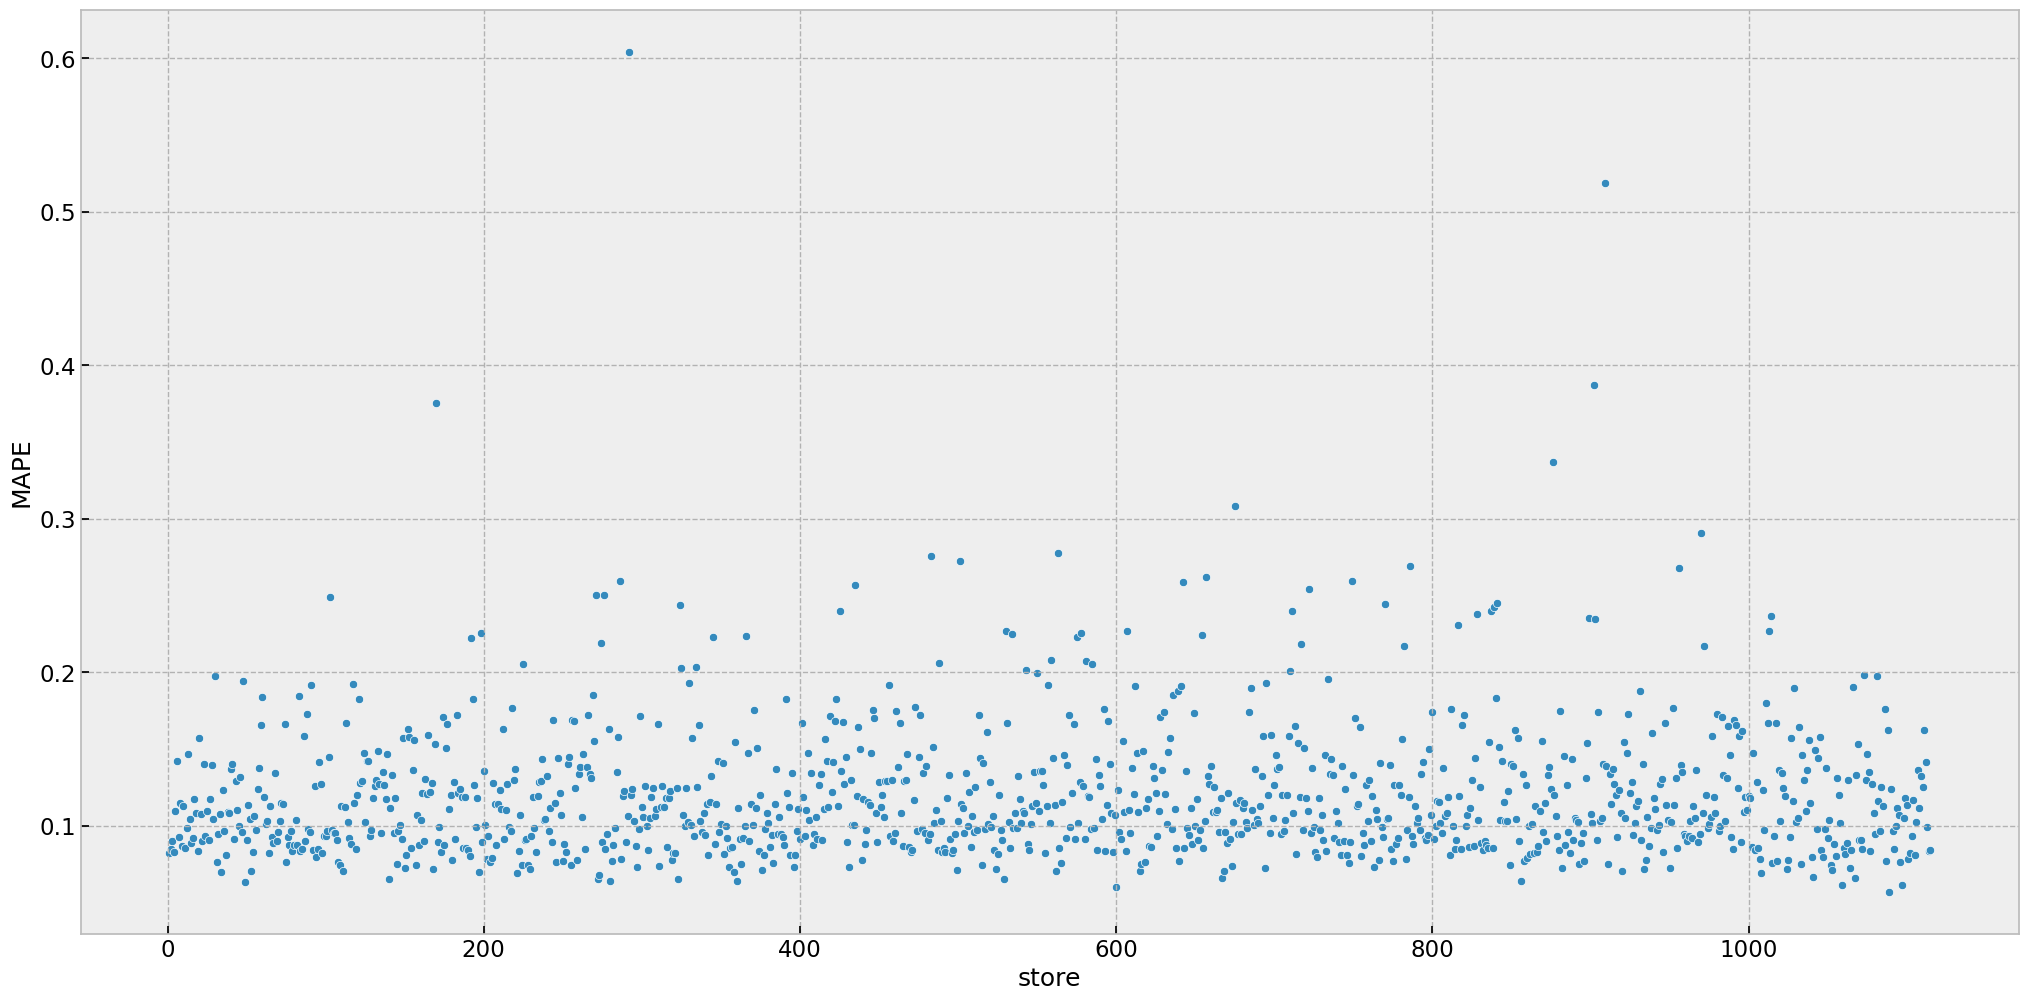

In [59]:
# Seta o valor da fonte a ser exibida
sns.set_context("notebook", font_scale=1.5)

sns.scatterplot(data=df92, x='store', y='MAPE')

## 9.2 Perfomance Total

In [23]:
df93 = (df92[['predictions', 'worst_scenario', 'best_scenario']]
         .apply(lambda x: np.sum(x), axis=0)
         .reset_index()
         .rename(columns={'index':'Scenario', 0:'Values'}))
df93['Values'] = df93['Values'].map('R$ {:,.2f}'.format)
df93

,Scenario,Values
0,predictions,"R$ 289,617,792.00"
1,worst_scenario,"R$ 288,737,682.22"
2,best_scenario,"R$ 289,617,931.66"


## 9.3 Perfomance em Machine Learning

In [61]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

C:\Users\garri\AppData\Local\Temp\ipykernel_6412\1385645114.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['error'] = df9['sales'] - df9['predictions']
C:\Users\garri\AppData\Local\Temp\ipykernel_6412\1385645114.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['error_rate'] = df9['predictions'] / df9['sales']


c:\Users\garri\anaconda3\envs\ds_producao\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\garri\anaconda3\envs\ds_producao\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


c:\Users\garri\anaconda3\envs\ds_producao\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\garri\anaconda3\envs\ds_producao\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\garri\anaconda3\envs\ds_producao\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\garri\anaconda3\envs\ds_producao\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be rem

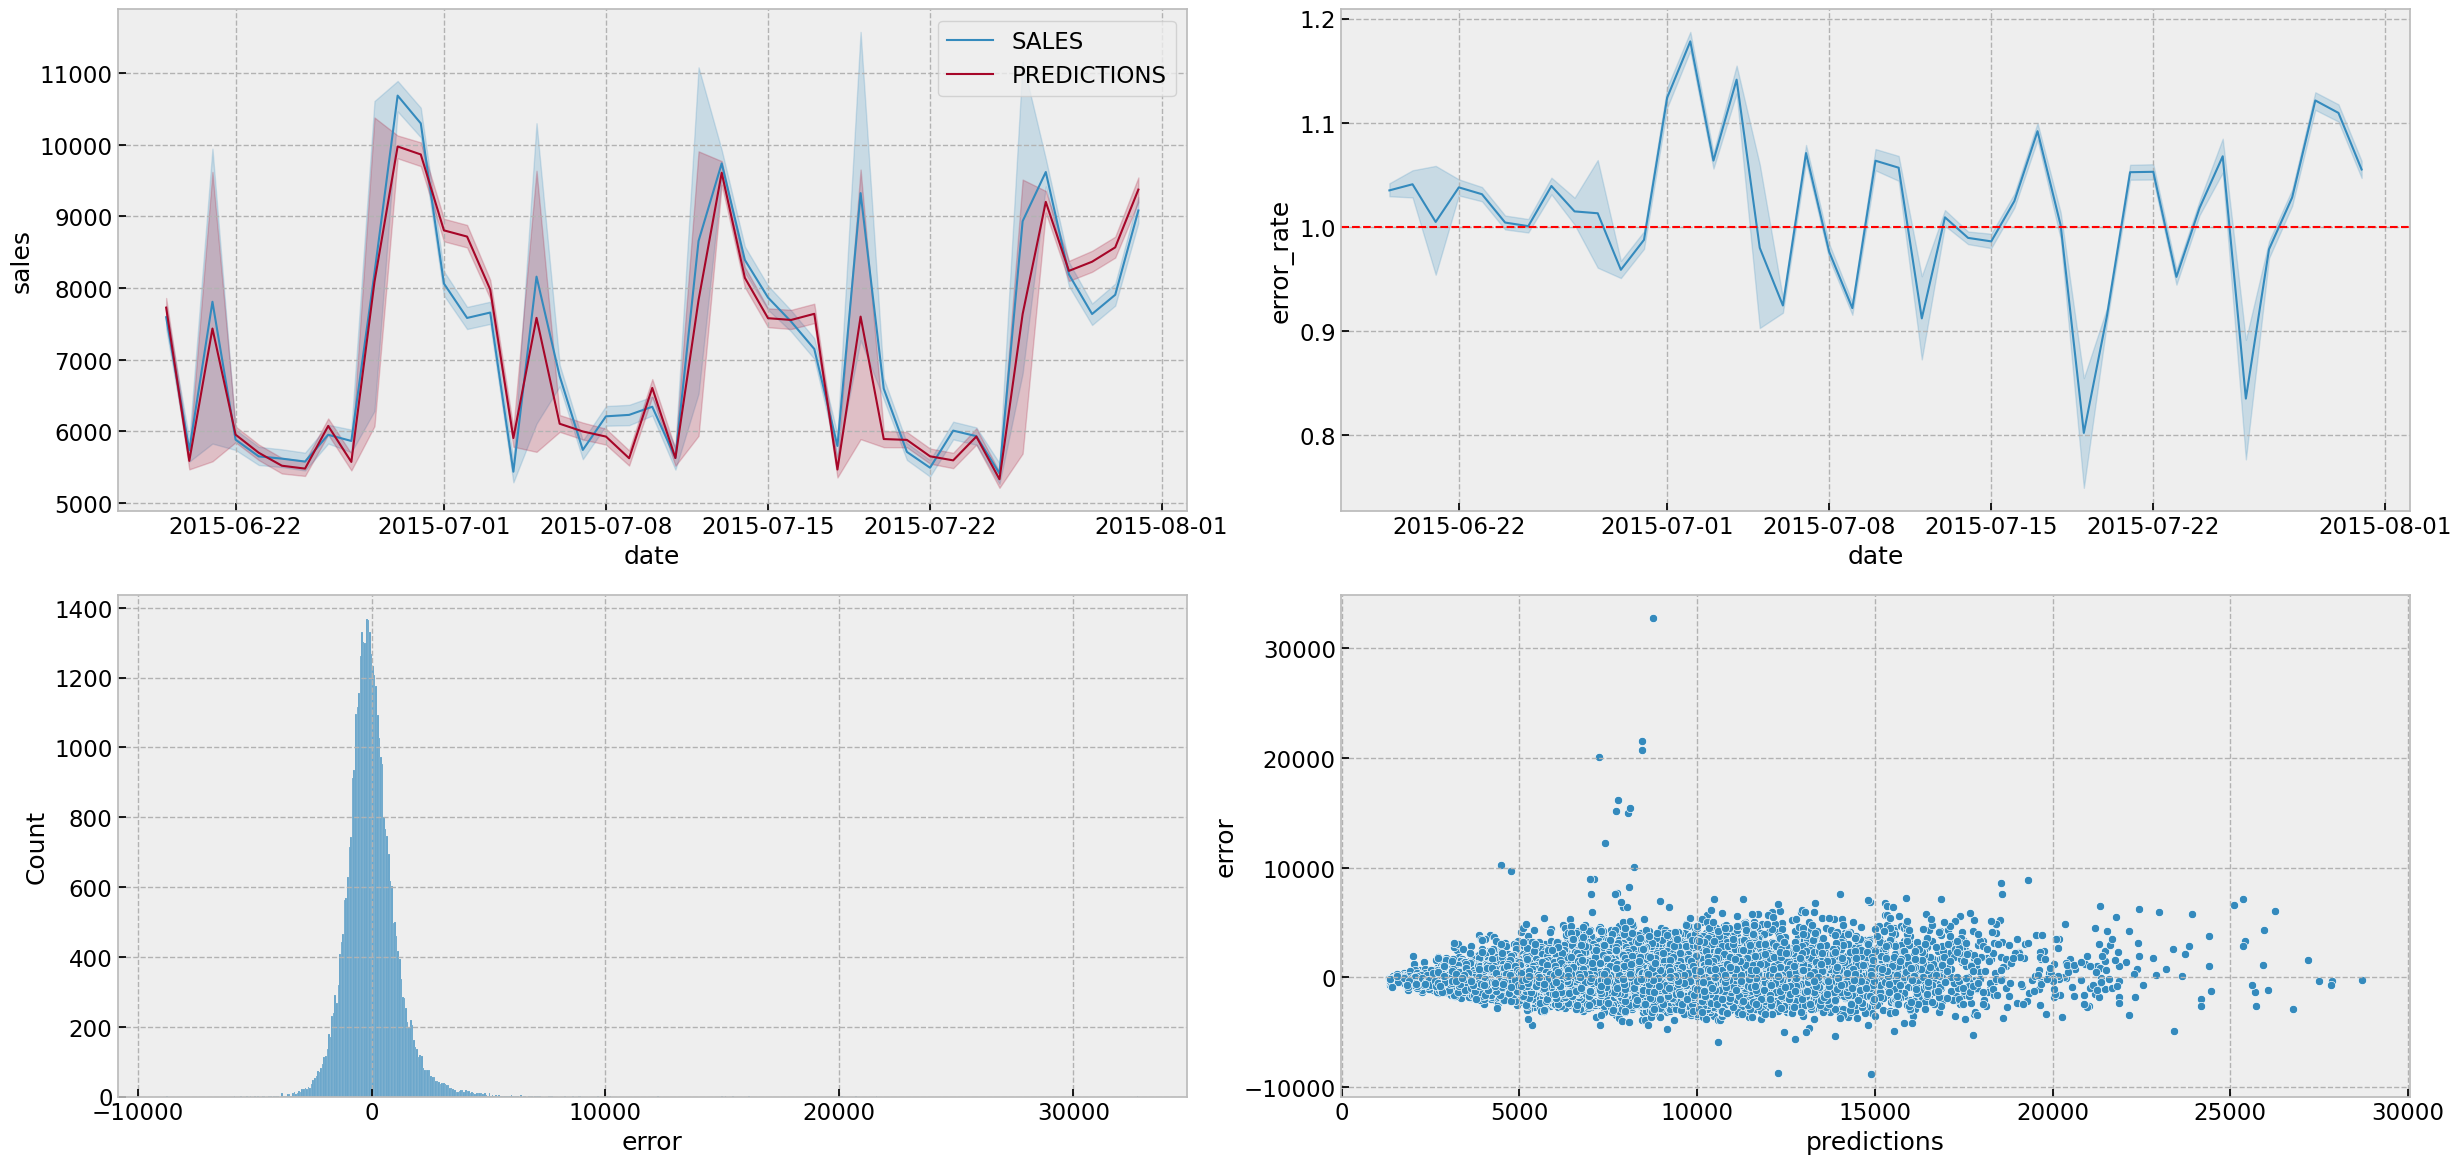

In [67]:
# Seta o valor da fonte a ser exibida
sns.set_context("notebook", font_scale=1.5)

# Subplot 1: Gráfico de linha para vendas e previsões
plt.subplot(2,2,1)
sns.lineplot(data=df9, x='date', y='sales', label='SALES')
sns.lineplot(data=df9, x='date', y='predictions', label='PREDICTIONS')

# Subplot 2: Gráfico de linha para taxa de erro
plt.subplot(2,2,2)
sns.lineplot(data=df9, x='date', y='error_rate')
plt.axhline(1, linestyle='--', color='red')  # Adiciona linha horizontal para a taxa de erro desejada

# Subplot 3: Histograma dos erros
plt.subplot(2,2,3)
sns.histplot(data=df9, x='error', kde=False)

# Subplot 4: Gráfico de dispersão de previsões vs erros
plt.subplot(2,2,4)
sns.scatterplot(data=df9, x='predictions', y='error')

# Ajustar o layout para evitar sobreposição
plt.tight_layout()

# Exibir o gráfico
plt.show()

# 10. Deploy do Modelo em Produção

1. Rodar os imports
2. Rodar funções auxiliares
3. Rodar a importação do modelo tunado
4. Rodar `carregando os dados` da parte de do deploy
5. Carregar os dados de df10
6. Carregar os snippets do API Tester

In [1]:
import pandas as pd
import numpy as np
import pickle
import inflection
import math
import datetime
import json
import requests

## Carregando dados

In [2]:
 # Dados unitários
df_sales_raw = pd.read_csv('../datasets/raw/train.csv', low_memory=False)
df_store_raw = pd.read_csv('../datasets/raw/store.csv', low_memory=False)

# dataset mesclado
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')   

## 10.1 Classe Rossmann

In [ ]:
class Rossman(object):
    def __init__(self):
        self.home_path='C:/Users/garri/Downloads/data_science/comunidadeds/7.data_science_producao/datasets/parametros/'
        self.competition_distance_scaler = pickle.load(open(self.home_path + 'competition_distance_scaler.pkl', 'rb'))
        self.competition_time_month_scaler = pickle.load(open(self.home_path + 'competition_time_month_scaler.pkl', 'rb'))
        self.competition_promo_time_week_scaler = pickle.load(open(self.home_path + 'competition_promo_time_week_scaler.pkl', 'rb'))
        self.year_scaler = pickle.load(open(self.home_path + 'year_scaler.pkl', 'rb'))
        self.store_type_scaler = pickle.load(open(self.home_path + 'store_type_scaler.pkl', 'rb'))
          
    def data_cleaning(self, df1):

        ### 1.1 Renomeando as colunas
        cols_old = ['Store', 'DayOfWeek', 'Date', 'Open', 'Promo',
                    'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
                    'CompetitionDistance', 'CompetitionOpenSinceMonth',
                    'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
                    'Promo2SinceYear', 'PromoInterval']

        # coloca as colunas com letras minusculas
        snakecase = lambda x: inflection.underscore(x)

        # cria as colunas padronizadas
        cols_new = list(map(snakecase, cols_old))

        # insere os novos nomes de colunas no dataset
        df1.columns = cols_new

        ## 1.3 Tipo de dados
        df1['date'] = pd.to_datetime(df1['date'])

        ## 1.5 Preenchendo NA
        
        # competition_distance
        # - O valor 200000 foi atribuído para simbolizar que a distancia de uma loja para outra é tão grande que não há competição entre as lojas
        df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

        # competition_open_since_month
        df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

        # competition_open_since_year
        df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

        # promo2_since_week
        df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

        # promo2_since_year
        df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

        # promo_interval
        # dicionario que altera o número do mês pelo nome do mês
        month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Out', 11: 'Nov', 12: 'Dec'}

        # substitui os na pelo valor 0
        df1['promo_interval'].fillna(0, inplace=True)

        # extrai o mês da data
        df1['month_map'] = df1['date'].dt.month.map(month_map)

        # verifica se o month map está contido na promo2
        df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

        ## 1.6 Alterando tipos de dados
        
        # competition
        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype('int64')
        df1['competition_open_since_year'] = df1['competition_open_since_year'].astype('int64')
        
        # promo2
        df1['promo2_since_week'] = df1['promo2_since_week'].astype('int64')
        df1['promo2_since_year'] = df1['promo2_since_year'].astype('int64')
        
        return df1
    
    def feature_engineering(self, df2):
        # year
        df2['year'] = df2['date'].dt.year

        # month
        df2['month'] = df2['date'].dt.month

        # day
        df2['day'] = df2['date'].dt.day

        # week of year
        df2['week_of_year'] = df2['date'].dt.isocalendar().week

        # year week
        df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

        # competiton since
        df2['competition_since'] = (df2.apply( lambda x: datetime.datetime(year=x['competition_open_since_year'],
                                                                        month=x['competition_open_since_month'],
                                                                        day=1), axis=1 ))

        df2['competition_time_month'] = ((df2['date'] - df2['competition_since'] ) / 30).apply(lambda x: x.days).astype('int64')

        # promo since
        df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
        df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))
        df2['promo_time_week'] = ((df2['date'] - df2['promo_since']) / 7).apply(lambda x: x.days).astype('int64')

        # assortment
        df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

        # state holiday
        df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public' if x == 'a' 
                                                          else 'easter_holiday' if x == 'b'
                                                          else 'christmas' if x == 'c'
                                                          else 'regular_day')

        df2 = df2[ df2['open'] != 0 ]
        ### 3.2 Seleção das Colunas
        # Seleção das colunas
        cols_drop = ['open', 'promo_interval', 'month_map']

        # Exclusão das colunas
        df2 = df2.drop(cols_drop, axis=1)
        
        return df2
    
    def data_preparation(self, df5):
        
        # 5.2 Rescaling
        # competition distance
        df5['competition_distance'] = self.competition_distance_scaler.fit_transform(df5[['competition_distance']].values)

        # competition time month
        df5['competition_time_month'] = self.competition_time_month_scaler.fit_transform(df5[['competition_time_month']].values)
        
        # promo time week
        df5['promo_time_week'] = self.competition_promo_time_week_scaler.fit_transform(df5[['promo_time_week']].values)
        
        # year
        df5['year'] = self.year_scaler.fit_transform(df5[['year']].values)
        
        # 5.3.1 Encoding        

        # state_holiday - One Hot Encoding
        df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])

        # store_type - Label Encoding

        df5['store_type'] = self.store_type_scaler.fit_transform(df5['store_type'])
        
        # assortment - Ordinal Encoding
        assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
        df5['assortment'] = df5['assortment'].map(assortment_dict)

        ### 5.3.3 Transformação de Natureza
        
        # day of week
        df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin( x * (2. * np.pi/7)))
        df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos( x * (2. * np.pi/7)))

        # month
        df5['month_sin'] = df5['month'].apply(lambda x: np.sin( x * (2. * np.pi/12)))
        df5['month_cos'] = df5['month'].apply(lambda x: np.cos( x * (2. * np.pi/12)))

        # day
        df5['day_sin'] = df5['day'].apply(lambda x: np.sin( x * (2. * np.pi/30)))
        df5['day_cos'] = df5['day'].apply(lambda x: np.cos( x * (2. * np.pi/30)))

        # week of year
        df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin( x * (2. * np.pi/52)))
        df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos( x * (2. * np.pi/52)))
        
        colunas_selecionadas = ['store', 'promo', 'store_type', 'assortment', 'competition_distance', 'competition_open_since_month',
            'competiton_open_since_year', 'promo2', 'promo2_since_week', 'promo2_since_year', 'competition_time_month', 'promo_time_week',
            'day_of_week_sin', 'day_of_week_cos', 'month_sin', 'month_cos', 'day_sin', 'day_cos' 'week_of_year_sin', 'week_of_year_cos']
        
        return df5[colunas_selecionadas]
    
    def get_prediction(self, model, original_data, test_data):
        # predição
        pred = model.predict(test_data)
        
        # Juntando a predição junto ao dataset original
        original_data['prediction'] = np.expm1(pred)
        
        return original_data.to_json(orient='records', date_format='iso')

## 10.2 API Handler

In [ ]:
import pandas as pd
import pickle
from flask import Flask, request, Response

from ..rossmann.Rossmann import Rossmann

# Carregando o modelo
model = pickle.load(open('datasets/modelos/final/model_rossmann.pkl', 'rb'))

# Inicializando o API
app = Flask(__name__)

@app.route('/rossmann/predict', methods=['POST'])

def rossmann_predict():
    test_json = request.get_json()
    
    if test_json: # se tiver dados
        
        if isinstance(test_json, dict): # Exemplo unico
            test_raw = pd.DataFrame(test_json, index=[0])
        else: # Exemplos multiplos
            test_raw = pd.DataFrame(test_json, columns=test_json[0].keys())
            
        # Instanciando a class rossmann
        pipeline = Rossmann()
        
        # Limpando os dados
        df1 = pipeline.data_cleaning(test_raw)
        
        # Feature engineering
        df2 = pipeline.feature_engineering(df1)
        
        # Data preparation
        df3 = pipeline.data_preparation(df2)
        
        # Prediction
        df_response = pipeline.get_prediction(model, test_raw, df3)
        
        return df_response
            
    else:
        return Response('{}', status=200, mimetype='application/json')

if __name__ == '__main__':
    app.run('127.0.0.1')

## 10.3 API Tester

In [3]:
# Carregando dados de teste
df10 = pd.read_csv('datasets/raw/test.csv')

In [4]:
# Mesclando dataset de test e store
df_test = pd.merge(df10, df_store_raw, how='left', on='Store')

# Escolhendo lojas para predição
df_test = df_test[df_test['Store'].isin([12,22,24])]

## Removendo dias que a loja ficaram fechados
df_test = df_test[df_test['Open'] != 0]
df_test = df_test[~df_test['Open'].isnull()]
df_test = df_test.drop('Id', axis=1)

In [5]:
# Convertendo o dataframe para o formato JSON
data = json.dumps(df_test.to_dict(orient='records'))

In [6]:
# API CALL
url = 'https://rossmann-store-predict.onrender.com/rossmann/predict'
header = {'Content-type': 'application/json'}
data = data

r = requests.post(url, data=data, headers=header)
print(f'Status Code {r.status_code}')

Status Code 200


In [7]:
d1 = pd.DataFrame(r.json(), columns=r.json()[0].keys())

In [8]:
d2 = d1[['store', 'prediction']].groupby('store').sum().reset_index()

for i in range(len(d2)):
    
    print(f'A Loja { d2.loc[i, "store"] } venderá {d2.loc[i, "prediction"]:,.2f} nas próximas 6 semanas')
    

A Loja 12 venderá 242,354.51 nas próximas 6 semanas
A Loja 22 venderá 143,758.31 nas próximas 6 semanas
A Loja 24 venderá 285,507.38 nas próximas 6 semanas


In [29]:
d2.head()

,store,prediction
0,12,242354.511719
1,22,143758.312988
2,24,285507.381836
